## Dalitz analysis of $B^0\to\bar D^0D_s^+\pi^-$ and $B^+\to D^-D_s^+\pi^+$
This ipython notebook is used for producing some plots in the Analysis Note (https://twiki.cern.ch/twiki/bin/viewauth/LHCbPhysics/B2DsDpi) in conjunction with the analysis package (https://github.com/ReynLieu/tf-pwa/tree/DDspi).

It is suggested you duplicate this notebook for your own use. You may search `edit here` in the comments in codes cells, which may help you navigate some places you need to edit.
### First, load the libraries and pre-defined functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy as sp
from scipy import stats
import math
from iminuit import Minuit
from pprint import pprint
import json

def error_print(x, err=None):
    if err is None:
        return ("{}").format(x)
    if err <= 0 or math.isnan(err):
        return ("{} ? {}").format(x, err)
    d = math.ceil(math.log10(err))
    b = 10 ** d
    b_err = err / b
    b_val = x / b
    if b_err < 0.355:  # 0.100 ~ 0.354
        dig = 2
    elif b_err < 0.950:  # 0.355 ~ 0.949
        dig = 1
    else:  # 0.950 ~ 0.999
        dig = 0
    err = round(b_err, dig) * b
    x = round(b_val, dig) * b
    d_p = dig - d
    if d_p > 0:
        return ("{0:.%df}±{1:.%df}" % (d_p, d_p)).format(x, err)
    return ("{0:.0f}±{1:.0f}").format(x, err)
def std_polar(r_l, p_l):
    sr_l = []
    sp_l = []
    for rho, phi in zip(r_l, p_l):
        if rho < 0:
            rho = -rho
            phi += math.pi
        while phi < -math.pi:
            phi += 2 * math.pi
        while phi > math.pi:
            phi -= 2 * math.pi
        sr_l.append(rho)
        sp_l.append(phi)
    return sr_l, sp_l

def rp2xy(r_l, p_l):
    if hasattr(r_l, '__len__'):
        x_l = []
        y_l = []
        for rho, phi in zip(r_l, p_l):
            x_l.append(rho*math.cos(phi))
            y_l.append(rho*math.sin(phi))
    else:
        x_l = r_l*math.cos(p_l)
        y_l = r_l*math.sin(p_l)
    return x_l, y_l

def xy2rp(x_l, y_l):
    if hasattr(x_l, '__len__'):
        r_l = []
        p_l = []
        for x, y in zip(x_l, y_l):
            r_l.append(math.sqrt(x*x+y*y))
            p_l.append(math.atan2(y,x))
    else:
        r_l = math.sqrt(x*x+y*y)
        p_l = math.atan2(y,x)
    return r_l, p_l
    
def BWRDspi(m, m0, g0, L, barrier=False):
    q = get_p(m, 1.96834, 0.13957039)
    q0 = get_p(m0, 1.96834, 0.13957039)
    p = get_p(5.27934, m, 1.86965)
    p0 = get_p(5.27934, m0, 1.86965)
    gamma = g0 * (q/q0)**(2*L+1) * m0/m * Bprime(q,q0,L)**2
    num = p**L * Bprime(p,p0,L) * q**L * Bprime(q,q0,L)
    x = m0 * m0 - m * m
    y = m0 * gamma
    s = x * x + y * y
    ret = tf.complex(x / s, y / s)
    if barrier:
        ret *= num
    return ret

def BWRDpi(m, m0, g0, L, barrier=False):
    p = get_p(5.27934, m, 1.96834)
    p0 = get_p(5.27934, m0, 1.96834)
    q = get_p(m, 1.86965, 0.13957039)
    if m0 < 1.86965+0.13957039:
        q0 = q
        Bprimeq = Bprime(q,0,L)
    else:
        q0 = get_p(m0, 1.86965, 0.13957039)
        Bprimeq = Bprime(q,q0,L)
    gamma = g0 * (q/q0)**(2*L+1) * m0/m * Bprimeq**2
    num = p**L * Bprime(p,p0,L) * q**L * Bprimeq
    x = m0 * m0 - m * m
    y = m0 * gamma
    s = x * x + y * y
    ret = tf.complex(x / s, y / s)
    if barrier:
        ret *= num
    return ret

def exp2(m, a, b=0):
    a=abs(a)
    zeros = tf.zeros_like(m)
    return tf.complex(tf.exp(-a * (m * m - b)), zeros)

def get_p(m_0, m_1, m_2):
    M12S = m_1 + m_2
    M12D = m_1 - m_2
    p = (m_0 - M12S) * (m_0 + M12S) * (m_0 - M12D) * (m_0 + M12D)
    return np.sqrt(p) / (2 * m_0)

def Bprime(q,q0,L,d=3.0):
    z = (q*d)**2
    z0 = (q0*d)**2
    if L == 0:
        return np.ones_like(q)
    if L == 1:
        return np.sqrt((z0+1)/(z+1))
    if L == 2:
        return np.sqrt((z0*z0+3*z0+9)/(z*z+3*z+9))
    if L == 3:
        return np.sqrt((z0*z0*z0+6*z0*z0+45*z0+225)/(z*z*z+6*z*z+45*z+225))
        
    
def normpdf(x, mu, sigma):
    return np.exp(-(x - mu) * (x - mu) / 2 / sigma / sigma) / np.sqrt(2 * np.pi) / sigma
def fitNormHist(data): # this function is used for Log-Likelihood fitting of Gaussian distribution
    data = np.array(data)
    def nll(mu, sigma):
        return -np.sum(np.log(normpdf(data, mu, sigma)))
    m = Minuit(nll, mu=0, sigma=1, error_mu=0.1, error_sigma=0.1, errordef=0.5)
    m.migrad()
    m.hesse()
    return m
def fitChi2Hist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df):
        return -np.sum(np.log(pdf(data, df)))
    m = Minuit(nll, errordef=0.5, df=2, error_df=0.1)
    m.migrad()
    m.hesse()
    return m
def fitChi2scHist(data, pdf, **kwargs): 
    data = np.array(data)
    def nll(df, scale):
        return -np.sum(np.log(pdf(data, df, 0, scale)))
    m = Minuit(nll, errordef=0.5, df=2, scale=1, error_df=0.1, error_scale=0.1)
    m.migrad()
    m.hesse()
    return m

def NLLfunc(data):
    def f(mu, sigma):
        return -np.sum(np.log(stats.norm.pdf(data, mu, sigma)))
    fitter = Minuit(f, mu=0, sigma=1, error_mu=1, error_sigma=1, errordef=0.5)
    return fitter

### Comparison of different MD description
This is the plot of MI S-wave and different MD curves on complex plane

/Users/lyret/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in sqrt


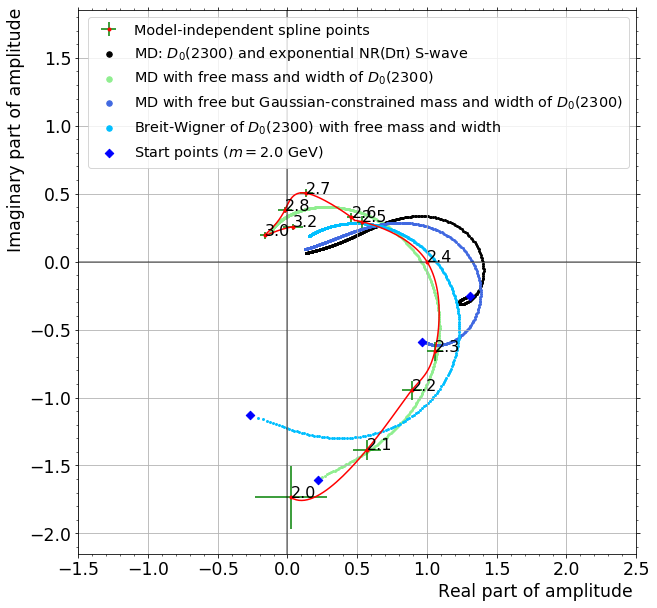

In [2]:
# MI
m_l = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2] # MI spline points (edit here)
m = np.linspace(m_l[0],m_l[-1],500)
value={ # paste from final_params.json (edit here)
    "DPi_S_point_0r": 0.025235101000149668,
    "DPi_S_point_0i": -1.7351579268388566,
    "DPi_S_point_1r": 0.567722983365226,
    "DPi_S_point_1i": -1.3860271194285592,
    "DPi_S_point_2r": 0.8906237166179922,
    "DPi_S_point_2i": -0.9470649433213484,
    "DPi_S_point_3r": 1.0566721291660692,
    "DPi_S_point_3i": -0.6591254699941851,
    "DPi_S_point_4r": 1.0,
    "DPi_S_point_4i": 0.0,
    "DPi_S_point_5r": 0.5321759530989049,
    "DPi_S_point_5i": 0.2938967360507145,
    "DPi_S_point_6r": 0.45861179273647323,
    "DPi_S_point_6i": 0.3246998928318995,
    "DPi_S_point_7r": 0.13492785218655,
    "DPi_S_point_7i": 0.5039594976564422,
    "DPi_S_point_8r": -0.01821207432992177,
    "DPi_S_point_8i": 0.3797317158391425,
    "DPi_S_point_9r": -0.16232365892723777,
    "DPi_S_point_9i": 0.1923629364023606,
    "DPi_S_point_10r": 0.0401392372923756,
    "DPi_S_point_10i": 0.2552673742544119,
}
error={ # paste from final_params.json (edit here)
    "DPi_S_point_0r": 0.2605550334069022,
    "DPi_S_point_0i": 0.23139376943681808,
    "DPi_S_point_1r": 0.09954626138580136,
    "DPi_S_point_1i": 0.07481197917365716,
    "DPi_S_point_2r": 0.07228943450801482,
    "DPi_S_point_2i": 0.07158086340770801,
    "DPi_S_point_3r": 0.059483661955368604,
    "DPi_S_point_3i": 0.06975354914332436,
    "DPi_S_point_5r": 0.0343810308561315,
    "DPi_S_point_5i": 0.04401145522578816,
    "DPi_S_point_6r": 0.03338677962340196,
    "DPi_S_point_6i": 0.03348865070811644,
    "DPi_S_point_7r": 0.047955025260362195,
    "DPi_S_point_7i": 0.027537633947978205,
    "DPi_S_point_8r": 0.04824422783348519,
    "DPi_S_point_8i": 0.019595030191093987,
    "DPi_S_point_9r": 0.0354172954741273,
    "DPi_S_point_9i": 0.0240673558015553,
    "DPi_S_point_10r": 0.07359405844405152,
    "DPi_S_point_10i": 0.023875016760250767,
}
# interpolated spline points. paste from the printout in tf_pwa.amp.interpolation "# for drawing on complex plane" (edit here)
MIreal = [0.02523510100024154, 0.04339096310438402, 0.06231853775074228, 0.08195638794792104, 0.10224307671626938, 0.12311716707315246, 0.14451722203070308, 0.16638180460433644, 0.18864947781405678, 0.21125880467141867, 0.2341483481959443, 0.25725667139929814, 0.2805223373006428, 0.30388390891258077, 0.3272799492528783, 0.3506490213384834, 0.37392968818539063, 0.3970605128046759, 0.41998005821532386, 0.44262688743482753, 0.464939563475653, 0.4868566493562175, 0.5083167080877623, 0.5292583026928821, 0.5496199961833306, 0.5693403595628567, 0.5883754830820722, 0.6067361237064799, 0.6244436714153556, 0.6415195161407496, 0.6579850478460633, 0.6738616564889782, 0.6891707320069684, 0.7039336643744681, 0.7181718435360446, 0.7319066594438941, 0.7451595020593228, 0.7579517613208205, 0.7703048272106283, 0.7822400896528506, 0.793778938622137, 0.8049427640607383, 0.8157529559210897, 0.8262309041688419, 0.8363979987507014, 0.8462756296299202, 0.8558851867450615, 0.86524806006067, 0.8743856395242895, 0.8833193150909412, 0.8920704603857482, 0.9006549088372902, 0.9090749131407359, 0.9173306831805403, 0.9254224287716146, 0.9333503598103821, 0.9411146861360569, 0.9487156176185321, 0.9561533641022911, 0.9634281354562899, 0.9705401415413286, 0.9774895922135766, 0.984276697323634, 0.990901666738148, 0.9973647103206119, 1.0036660379182731, 1.0098058594026824, 1.0157843846246983, 1.0216018234329425, 1.0272583857229058, 1.032754281294126, 1.0380897200589678, 1.043264911847025, 1.0482800665309886, 1.0531353939750387, 1.057830979054244, 1.0623517856674118, 1.0666534105229193, 1.0706880761928521, 1.0744080052678762, 1.0777654203320195, 1.0807125439605632, 1.0832015987434087, 1.0851848072622194, 1.08661439211073, 1.087442575874221, 1.0876215811222092, 1.0871036304500574, 1.0858409464434353, 1.0837857516637135, 1.0808902687263982, 1.0771067202092603, 1.0723873286810335, 1.0666843167437672, 1.0599499069601843, 1.0521363219406255, 1.0431957842589534, 1.033080516502567, 1.0217427412416027, 1.0091346810777924, 0.995209580745686, 0.9799820150615162, 0.9635616204161482, 0.946066210526218, 0.9276135991303324, 0.9083215999542387, 0.8883080267110822, 0.8676906931607364, 0.846587413007595, 0.8251159999904605, 0.8033942678216689, 0.7815400302427777, 0.7596711009924662, 0.7379052937738546, 0.7163604223187929, 0.6951543003758265, 0.6744047416505713, 0.6542295598886995, 0.6347465688087436, 0.6160735821396781, 0.5983284136082199, 0.5816288769412786, 0.5660927858742789, 0.5518379541476142, 0.538982195454628, 0.5276405638602826, 0.5178306853653936, 0.5094490467016605, 0.5023845620314304, 0.4965261455055923, 0.49176271125245047, 0.4879831734528859, 0.4850764462309076, 0.4829314437649942, 0.4814370801869145, 0.48048226965068097, 0.4799559263231575, 0.47974696432491054, 0.47974429782365313, 0.47983684098643403, 0.4799135079343152, 0.4798632128413485, 0.47957486984346404, 0.4789373931004521, 0.47783969676734217, 0.47617069497497316, 0.4738193018995002, 0.47067443167057116, 0.46662499846003663, 0.46155991640593336, 0.4553720097206451, 0.4480440339013878, 0.439648675776163, 0.43026253222501976, 0.41996220009010815, 0.40882427624863293, 0.39692535759107456, 0.38434204095206354, 0.37115092322839627, 0.3574286012798326, 0.3432516719805056, 0.328696732200151, 0.31384037879882937, 0.298759208654426, 0.2835298186282417, 0.2682288056040799, 0.2529327664440493, 0.23771829801243138, 0.22266199718601268, 0.2078404608281914, 0.1933302858164361, 0.179208069025178, 0.16555040730377305, 0.15243389753268352, 0.13993513658140894, 0.128127124015581, 0.11702531286609535, 0.10659887355598707, 0.0968156655345088, 0.0876435482475275, 0.07905038113371012, 0.07100402365250748, 0.0634723352349497, 0.05642317533423235, 0.04982440339591918, 0.04364387886291791, 0.03784946118575771, 0.032409009803427424, 0.02729038417000411, 0.022461443723266063, 0.017890047913225467, 0.013544056190287182, 0.009391327990042221, 0.0053997227618395715, 0.0015370999552748383, -0.0022286809867372985, -0.005929760618543694, -0.009598279495691852, -0.013266378171693991, -0.016966197195515016, -0.02072796591901094, -0.024559695866617014, -0.028455064495494717, -0.03240751035832894, -0.036410472009537585, -0.040457388002892086, -0.0445416968915213, -0.048656837228876905, -0.05279624756995314, -0.056953366467628545, -0.061121632475574596, -0.06529448414758576, -0.06946536003728655, -0.07362769869908103, -0.07777493868561275, -0.08190051855172309, -0.08599787685009919, -0.09006045213488689, -0.0940816829595286, -0.09805500787888703, -0.10197386544526935, -0.10583169421296107, -0.10962193273529454, -0.11333801956679286, -0.11697339326076919, -0.12052149237063407, -0.12397575545060739, -0.12732962105422327, -0.1305765277353411, -0.1337099140467545, -0.13672321854274552, -0.13960987977824302, -0.14236333630506887, -0.14497702667762905, -0.1474443894509925, -0.14975886317654424, -0.15191388640890202, -0.1539028977028354, -0.1557193356108954, -0.15735663868700694, -0.15880824548483588, -0.160067594558456, -0.1611281244617135, -0.16198327374697527, -0.16262648097001814, -0.16305118468279328, -0.163250823440562, -0.16321883579540192, -0.16294866030247485, -0.16243373551425425, -0.16166881043785153, -0.16065734596723685, -0.15940635694321117, -0.15792286869133773, -0.15621390653599274, -0.15428649580215487, -0.15214766181484318, -0.14980442989945586, -0.14726382537998534, -0.144532873581193, -0.14161859982932407, -0.13852802944771173, -0.1352681877624171, -0.13184610009747563, -0.1282687917779846, -0.12454328812942204, -0.12067661447602854, -0.11667579614268889, -0.11254785845476217, -0.10829982673690569, -0.10393872631382907, -0.09947158251040303, -0.09490542065217827, -0.09024726606284132, -0.08550414406845172, -0.08068307999346483, -0.07579109916280484, -0.07083522690070367, -0.06582248853284679, -0.06075990938412276, -0.05565451477925044, -0.05051333004317575, -0.04534338050007254, -0.04015169147609137, -0.03494528829537556, -0.029731196282614957, -0.024516440762839452, -0.0193080470611613, -0.014113040502916147, -0.008938446412047989, -0.0037912901136086807, 0.0013214030667292112, 0.006392607804657571, 0.011415298775678095, 0.01638245065426246, 0.021287038115659396, 0.026122035834984365, 0.030880418487766313, 0.035555160748611724, 0.04013923729221258]
MIimag = [-1.7351579268426323, -1.745386220567511, -1.7524112803984753, -1.7563870784773918, -1.757467586952329, -1.7558067779811009, -1.7515586236882552, -1.7448770962452609, -1.7359161677898383, -1.7248298104718867, -1.7117719964365454, -1.6968966978328364, -1.680357886812903, -1.6623095355137616, -1.6429056160984317, -1.6223001007041566, -1.6006469614790602, -1.5781001705807858, -1.5548137001427345, -1.53094152232576, -1.5066376092597449, -1.4820559331161416, -1.4573504660180445, -1.4326751801446158, -1.4081840476134904, -1.3840310260886217, -1.3603382926845549, -1.3371288569273652, -1.31440643980003, -1.2921747622266988, -1.2704375451705183, -1.249198509570731, -1.228461376367574, -1.2082298665393711, -1.1885077010097902, -1.169298600738133, -1.1506062866677351, -1.1324344797362274, -1.1147869009244036, -1.097667271141417, -1.081079311378908, -1.0650267425475757, -1.0495132856027138, -1.0345426615096869, -1.020118591205385, -1.0062447956556488, -0.9929249957743013, -0.9801629125447227, -0.9679622668904048, -0.9563267797670268, -0.9452601110723742, -0.9347452149882495, -0.9247142894628895, -0.915091897612609, -0.9058026025013041, -0.8967709672666595, -0.8879215549930576, -0.8791789287854352, -0.8704676517336227, -0.8617122869566061, -0.8528373975411195, -0.8437675466033994, -0.8344272972241165, -0.8247412125213247, -0.8146338555959572, -0.8040297895382386, -0.79285357745563, -0.7810297824504229, -0.7684829676164711, -0.7551376960828219, -0.7409185308931938, -0.7257500352094609, -0.7095567720951179, -0.6922633046670297, -0.673794196031896, -0.654074454374326, -0.6330829444476206, -0.6109031284597831, -0.5876304861918055, -0.5633604974269837, -0.5381886419455718, -0.512210399521327, -0.48552124994559215, -0.4582166729935968, -0.430392148457803, -0.40214315610849627, -0.37356517572632497, -0.3447536871069782, -0.3158041700192594, -0.28681210424506964, -0.25787296956728223, -0.2290822457746497, -0.2005354126380837, -0.17232794994401884, -0.14455533747130436, -0.11731305500923393, -0.09069658233130803, -0.06480139922444313, -0.03972298546820108, -0.015556820843096545, 0.007602332982222779, 0.029702800204716273, 0.05075968823751685, 0.07079384926255453, 0.08982613544738574, 0.10787739898571441, 0.12496849205782395, 0.1411202668341497, 0.15635357550542187, 0.1706892702471326, 0.1841482032402262, 0.19675122666781042, 0.2085191927016321, 0.21947295353673002, 0.22963336134785292, 0.2390212683085182, 0.24765752660583487, 0.2555629884233267, 0.2627585059392184, 0.2692649313279547, 0.2751031167800672, 0.28029391447263147, 0.28485817658240525, 0.28881675529121337, 0.2921905027891915, 0.2950006429766682, 0.2972815237063085, 0.2990838107018937, 0.30045918974424923, 0.30145934663171325, 0.30213596713436586, 0.3025407370565035, 0.30272534216873115, 0.30274146826992293, 0.30264080114128583, 0.30247502656685166, 0.3022958303472206, 0.30215489824737923, 0.30210391606198617, 0.30219456959143265, 0.30247854460091095, 0.30300752689065996, 0.30383320224029814, 0.3050072564375138, 0.30658137527807117, 0.3086072445376226, 0.3111365500075473, 0.31422097746725336, 0.31791221271286835, 0.32226194152499954, 0.32731935688830543, 0.33307631708849106, 0.3394673457936375, 0.34642447382921465, 0.35387973200608325, 0.36176515116871244, 0.3700127621622804, 0.3785545957819987, 0.38732268288102184, 0.39624905428964013, 0.4052657408409691, 0.41430477335784227, 0.4232981826607856, 0.4321779996029929, 0.4408762549982058, 0.44932497968380974, 0.4574562044873394, 0.465201960236921, 0.47249427777549546, 0.47926518791502964, 0.4854467214973428, 0.4909709093612286, 0.49576978231403895, 0.4997753712018559, 0.5029197068445066, 0.5051385540104546, 0.5064274091553566, 0.5068298088888815, 0.5063906505826207, 0.5051548315872642, 0.5031672492604924, 0.5004728009796959, 0.4971163840942016, 0.4931428959634338, 0.48859723395056137, 0.4835242954152223, 0.47796897772992025, 0.4719761782357089, 0.4655907943055438, 0.4588577232965979, 0.4518218625732168, 0.44452810949486, 0.4370213614214187, 0.4293465157063594, 0.42154846972595833, 0.41367212083310356, 0.40576236638458785, 0.39786410374610537, 0.3900222302719039, 0.3822816433328109, 0.3746850050552389, 0.3672489930883168, 0.3599735208762886, 0.3528582224654464, 0.3459027319057239, 0.33910668323736476, 0.3324697105109419, 0.3259914477743376, 0.31967152907128027, 0.31350958844659144, 0.30750525995259137, 0.3016581776305308, 0.2959679755289935, 0.2904342876914314, 0.285056748168999, 0.2798349910036253, 0.27476865024443814, 0.2698573599405283, 0.26510075413319334, 0.26049846686980144, 0.2560501321996749, 0.25175538416668897, 0.24761385681997117, 0.24362518420080298, 0.239789000360174, 0.23610493934464297, 0.23257263519902938, 0.2291917219663659, 0.2259618337015854, 0.22288260444364533, 0.21995366824421425, 0.21717465914478443, 0.21454521119659, 0.21206495844068615, 0.20973353492715685, 0.2075505747016645, 0.20551571181189904, 0.2036285803039858, 0.20188881421962415, 0.2002960476134775, 0.19884991452653122, 0.19755004900683013, 0.1963960850973676, 0.19538765685337983, 0.19452439830898902, 0.19380594352346903, 0.1932319265326863, 0.1928019813876051, 0.19251574213436956, 0.1923728428214831, 0.19237242821400685, 0.19251039033318937, 0.19278129427943577, 0.1931797012333303, 0.19370017237752077, 0.19433726889281594, 0.19508555196157462, 0.1959395827657285, 0.19689392248707738, 0.19794313230760532, 0.19908177340921082, 0.2003044069739193, 0.2016055941823476, 0.20297989621779658, 0.2044218742624463, 0.20592608949668773, 0.2074871031033911, 0.20909947626337425, 0.21075777016014044, 0.2124565459741983, 0.21419036488841825, 0.2159537880840854, 0.21774137674293023, 0.21954769204726884, 0.22136729517797643, 0.22319474731839573, 0.2250246096499615, 0.22685144335417157, 0.22866980961294192, 0.23047426960763617, 0.23225938452135508, 0.23401971553495587, 0.2357498238306868, 0.2374442705910973, 0.23909761699659451, 0.24070442422972183, 0.24225925347317478, 0.24375666590735776, 0.2451912227145217, 0.24655748507774372, 0.2478500141780101, 0.2490633711972611, 0.2501921173164397, 0.25123081371902883, 0.25217402158578855, 0.25301630209941356, 0.25375221644174023, 0.2543763257926325, 0.254883191336938, 0.25526737425369134]
totamp_MI = complex(*rp2xy(1.0839317060867066, -1.1109851958731785)) # (edit here)

# MD 2300 + expNR
m2300=2.343; g2300=0.229; exp_a=0.3521134666292743; m2900=2.9; g2900=0.1 # edit here
totamp_BW2300 = complex(*rp2xy(0.3556530254023383, -2.3524809293267)) # edit here
BW2300 = BWRDpi(m, m2300, g2300, L=0).numpy() * totamp_BW2300 / totamp_MI
totamp_expNR = complex(*rp2xy(1.3543855454190625, -1.1447679368047623)) # edit here
expNR = exp2(m, exp_a, b=4).numpy() * totamp_expNR / totamp_MI
totamp_BW2900 = complex(*rp2xy(0, 0)) # edit here
BW2900 = 0 #BWRDpi(m, m2900, g2900, L=0).numpy() * totamp_BW2900 / totamp_MI
MD = BW2300 + expNR + BW2900
MD = MD[~np.isnan(MD)]

# 2300 (free mass and width) + expNR
m2300=2.461836622829603; g2300=0.6769961172176616; exp_a=0.20176395100601927; m2900=2.9; g2900=0.1
totamp_BW2300 = complex(*rp2xy(2.278719754462347, -2.083198504722652))
BW2300 = BWRDpi(m, m2300, g2300, L=0).numpy() * totamp_BW2300 / totamp_MI
totamp_expNR = complex(*rp2xy(0.9300106235588532, 3.1337069075801396))
expNR = exp2(m, exp_a, b=4).numpy() * totamp_expNR / totamp_MI
totamp_BW2900 = complex(*rp2xy(0, 0)) # edit here
BW2900 = 0 #BWRDpi(m, m2900, g2900, L=0).numpy() * totamp_BW2900 / totamp_MI
MD1 = BW2300 + expNR + BW2900
MD1 = MD1[~np.isnan(MD1)]

# 2300 (gaussian-constrained mass and width) + expNR
m2300=2.331605067720551; g2300=0.3290394054751804; exp_a=0.322124713674233; m2900=2.9; g2900=0.1
totamp_BW2300 = complex(*rp2xy(0.6330610393806273, -2.448223909261534))
BW2300 = BWRDpi(m, m2300, g2300, L=0).numpy() * totamp_BW2300 / totamp_MI
totamp_expNR = complex(*rp2xy(0.9661258343050956, -1.3261335031189616))
expNR = exp2(m, exp_a, b=4).numpy() * totamp_expNR / totamp_MI
totamp_BW2900 = complex(*rp2xy(0, 0)) # edit here
BW2900 = 0 #BWRDpi(m, m2900, g2900, L=0).numpy() * totamp_BW2900 / totamp_MI
MD2 = BW2300 + expNR + BW2900
MD2 = MD2[~np.isnan(MD2)]

# 2300 (gaussian-constrained mass and width)
m2300=2.280529844683593; g2300=0.47039389213204813
totamp_BW2300 = complex(*rp2xy(1.4649244444968035, -2.9448369239314873))
BW2300 = BWRDpi(m, m2300, g2300, L=0).numpy() * totamp_BW2300 / totamp_MI
MD3 = BW2300
MD3 = MD3[~np.isnan(MD3)]

x_l = []
y_l = []
x_el = []
y_el = []
for v in value:
    if "DPi_S_point" in v:
        if v.endswith('r'):
            x_l.append(value[v])
            x_el.append(error.get(v,0))
        elif v.endswith('i'):
            y_l.append(value[v])
            y_el.append(error.get(v,0))

plt.figure(figsize=[10,10])
plt.errorbar(x_l, y_l, label="Model-independent spline points",xerr=x_el,yerr=y_el,fmt="r.",ecolor='g')
plt.plot()
plt.plot(MIreal, MIimag, 'r')
plt.scatter(MD.real, MD.imag, label=f"MD: $D_0(2300)$ and exponential NR(Dπ) S-wave",s=15,marker=".",color='k')
plt.scatter([MD.real[0]],[MD.imag[0]],marker="D",color='b', label=f"Start points ($m={m_l[0]}$ GeV)")
# more cases below
plt.scatter(MD1.real, MD1.imag, label=f"MD with free mass and width of $D_0(2300)$",s=15,marker=".",color='lightgreen')
plt.scatter([MD1.real[0]],[MD1.imag[0]],marker="D",color='b')
plt.scatter(MD2.real, MD2.imag, label=f"MD with free but Gaussian-constrained mass and width of $D_0(2300)$",s=15,marker=".",color='royalblue')
plt.scatter([MD2.real[0]],[MD2.imag[0]],marker="D",color='b')
plt.scatter(MD3.real, MD3.imag, label=f"Breit-Wigner of $D_0(2300)$ with free mass and width",s=15,marker=".",color='deepskyblue')
plt.scatter([MD3.real[0]],[MD3.imag[0]],marker="D",color='b')

xmin, xmax = [-1.5,2.5] # plot x range (edit here)
ymin, ymax = [-2.15,1.85] # plot y range (edit here)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
pos=0.8
plt.xlabel("Real part of amplitude", fontsize="xx-large", position=[0.82,0])
plt.ylabel("Imaginary part of amplitude", fontsize="xx-large", position=[0,0.78])
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
#plt.title(r"Comparison between model-independent and model-dependent description of S-wave", fontsize="xx-large")
for i in range(len(x_l)):
    plt.text(x_l[i], y_l[i], m_l[i], fontsize=16)
    
handles, labels = plt.gca().get_legend_handles_labels()
#order = [2,0,1] # the order of legends (edit here, in case you need to add/remove MD cases)
order = [5,0,2,3,4,1]
lgnd = plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize='x-large')
# the marker size of each legend (edit here)
lgnd.legendHandles[1]._sizes = [120]; lgnd.legendHandles[2]._sizes = [120]; lgnd.legendHandles[3]._sizes = [120]; lgnd.legendHandles[4]._sizes = [120];

plt.plot([0,0],[ymin, ymax],"k",alpha=0.5)
plt.plot([xmin, xmax],[0,0],"k",alpha=0.5)
plt.grid()
plt.tick_params(top='on', right='on', which='both')
plt.minorticks_on()
plt.savefig("/Users/lyret/Desktop/temp/DDspi_latexfigs/MIvsMDmore.pdf") # save path (edit here)
plt.show()

### Argand plots of Z
This plot is used to compare the BW and MI description of $Z_0$. Using the package, you need to fit $Z_0$ with BW first, and then use MI hist points to replace the BW model and fit again. 

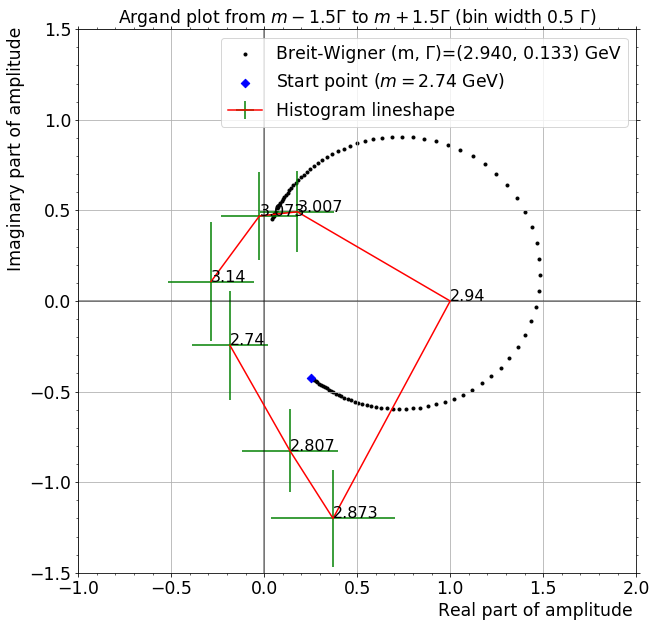

In [3]:
m_l = [2.740,2.807,2.873,2.940,3.007,3.073,3.140] # The points of MI hist (edit here)
m = np.linspace(m_l[0],m_l[-1],100)
value={ # paste from final_params.json (edit here)
  "Z0hist_point_0r": -0.18398201463793815,
  "Z0hist_point_0i": -0.24500178339543127,
  "Z0hist_point_1r": 0.13809670132268573,
  "Z0hist_point_1i": -0.8260127593220411,
  "Z0hist_point_2r": 0.3700066010915961,
  "Z0hist_point_2i": -1.1999472136685472,
  "Z0hist_point_3r": 1.0,
  "Z0hist_point_3i": 0.0,
  "Z0hist_point_4r": 0.17812997689662294,
  "Z0hist_point_4i": 0.4922084622746142,
  "Z0hist_point_5r": -0.025689041696141682,
  "Z0hist_point_5i": 0.4693704259301117,
  "Z0hist_point_6r": -0.2856576937210685,
  "Z0hist_point_6i": 0.10758650270975266,
}
error={ # paste from final_params.json (edit here)
 'Z0hist_point_0i': 0.29897309992314725,
 'Z0hist_point_0r': 0.20258593690580923,
 'Z0hist_point_1i': 0.2304494589602429,
 'Z0hist_point_1r': 0.2585744242864387,
 'Z0hist_point_2i': 0.2657296620803313,
 'Z0hist_point_2r': 0.33470509263491266,
 'Z0hist_point_4i': 0.22353293283661171,
 'Z0hist_point_4r': 0.19841787366739477,
 'Z0hist_point_5i': 0.2426667482885338,
 'Z0hist_point_5r': 0.2089565754078067,
 'Z0hist_point_6i': 0.3266315958740201,
 'Z0hist_point_6r': 0.2302349590095109
}
# the fit results from BW fit (edit here m0, g0, BWamp, MIamp)
m0=2.940008522304044 
g0=0.13328681927235833
BWamp = complex(*rp2xy(-0.12024044281525945, 2.736390880543188)) # note the pasted value is from polar coord, then rp2xy transform that into xy
MIamp = complex(*rp2xy(0.20472627357890252,0.9182976151997726))
bw = BWRDspi(m, m0=m0, g0=g0, L=0) * BWamp / MIamp
bw = bw.numpy()

x_l = []
y_l = []
x_el = []
y_el = []
for v in value:
    if "Z0hist_point" in v:
        if v.endswith('r'):
            x_l.append(value[v])
            x_el.append(error.get(v,0))
        elif v.endswith('i'):
            y_l.append(value[v])
            y_el.append(error.get(v,0))
            
plt.figure(figsize=[10,10])
plt.errorbar(x_l, y_l, label="Histogram lineshape",xerr=x_el,yerr=y_el,fmt="r-",ecolor='g')
plt.plot()
#plt.scatter([x_l[0]],[y_l[0]],marker=",",color='r', label="Start point")
#plt.errorbar(bw.real, bw.imag, label="Breit-Wigner",xerr=0,yerr=0,fmt="b-",)
plt.scatter(bw.real, bw.imag, label=f"Breit-Wigner (m, Γ)=({m0:.3f}, {g0:.3f}) GeV",marker=".",color='k',)
plt.scatter([bw.real[0]],[bw.imag[0]],marker="D",color='b', label=f"Start point ($m={m_l[0]}$ GeV)")
#plt.scatter([0],[0],marker="+",color='k')
xmin, xmax = [-1,2] # x plot range (edit here)
ymin, ymax = [-1.5,1.5] # y plot range (edit here)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
pos=0.8
plt.xlabel("Real part of amplitude", fontsize="xx-large", position=[0.82,0])
plt.ylabel("Imaginary part of amplitude", fontsize="xx-large", position=[0,0.78])
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.title(r"Argand plot from $m-1.5\Gamma$ to $m+1.5\Gamma$ (bin width 0.5 $\Gamma$)", fontsize="xx-large")
for i in range(len(x_l)):
    plt.text(x_l[i], y_l[i], m_l[i], fontsize=16)
plt.legend(fontsize='xx-large')

plt.plot([0,0],[ymin, ymax],"k",alpha=0.5)
plt.plot([xmin, xmax],[0,0],"k",alpha=0.5)
plt.grid()
plt.tick_params(top='on', right='on', which='both')
plt.minorticks_on()
plt.savefig("/Users/lyret/Desktop/temp/DDspi_latexfigs/argandZ0.pdf") # save path (edit here)
plt.show()

Very similarly, this plot is for $Z_1$.

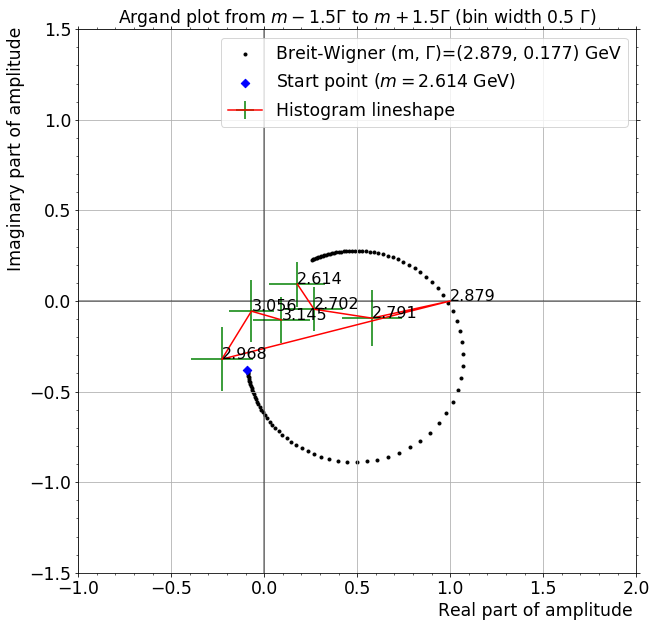

In [4]:
m_l = [2.614,2.702,2.791,2.879,2.968,3.056,3.145] # The points of MI hist (edit here)
m = np.linspace(m_l[0],m_l[-1],100)
value={ # paste from final_params.json (edit here)
    "Z1hist_point_0r": 0.17802081443842402,
    "Z1hist_point_0i": 0.09312836715359137,
    "Z1hist_point_1r": 0.2681319914992977,
    "Z1hist_point_1i": -0.04549524598251586,
    "Z1hist_point_2r": 0.5793298681852703,
    "Z1hist_point_2i": -0.09450568251054856,
    "Z1hist_point_3r": 1.0,
    "Z1hist_point_3i": 0.0,
    "Z1hist_point_4r": -0.2277270371415337,
    "Z1hist_point_4i": -0.32103816547266656,
    "Z1hist_point_5r": -0.06877129413714869,
    "Z1hist_point_5i": -0.05616452361058719,
    "Z1hist_point_6r": 0.09265729916477207,
    "Z1hist_point_6i": -0.10411081913016615,
}
error={ # paste from final_params.json (edit here)
    "Z1hist_point_0r": 0.1512775795147309,
    "Z1hist_point_0i": 0.12375972887418413,
    "Z1hist_point_1r": 0.15554510659943452,
    "Z1hist_point_1i": 0.12039593014330469,
    "Z1hist_point_2r": 0.15955152106243997,
    "Z1hist_point_2i": 0.1556047439408757,
    "Z1hist_point_4r": 0.16517171242550033,
    "Z1hist_point_4i": 0.17500531261345434,
    "Z1hist_point_5r": 0.12244110806450487,
    "Z1hist_point_5i": 0.17191851365839958,
    "Z1hist_point_6r": 0.15224371442915496,
    "Z1hist_point_6i": 0.1273852170655738,
}
# the fit results from BW fit (edit here m0, g0, BWamp, MIamp)
m0=2.879371030465782
g0=0.17708387373945192
BWamp = complex(*rp2xy(0.41031724761653193, 0.8110649866257647))
MIamp = complex(*rp2xy(-0.6969494379289713,-0.28635910321591646))
bw = BWRDspi(m, m0=m0, g0=g0, L=1) * BWamp / MIamp # note that here L=1
bw = bw.numpy()

x_l = []
y_l = []
x_el = []
y_el = []
for v in value:
    if "Z1hist_point" in v:
        if v.endswith('r'):
            x_l.append(value[v])
            x_el.append(error.get(v,0))
        elif v.endswith('i'):
            y_l.append(value[v])
            y_el.append(error.get(v,0))
            
plt.figure(figsize=[10,10])
plt.errorbar(x_l, y_l, label="Histogram lineshape",xerr=x_el,yerr=y_el,fmt="r-",ecolor='g')
plt.plot()
#plt.scatter([x_l[0]],[y_l[0]],marker=",",color='r', label="Start point")
#plt.errorbar(bw.real, bw.imag, label="Breit-Wigner",xerr=0,yerr=0,fmt="b-",)
plt.scatter(bw.real, bw.imag, label=f"Breit-Wigner (m, Γ)=({m0:.3f}, {g0:.3f}) GeV",marker=".",color='k',)
plt.scatter([bw.real[0]],[bw.imag[0]],marker="D",color='b', label=f"Start point ($m={m_l[0]}$ GeV)")
#plt.scatter([0],[0],marker="+",color='k')
xmin, xmax = [-1,2] # x plot range (edit here)
ymin, ymax = [-1.5,1.5] # y plot range (edit here)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
pos=0.8
plt.xlabel("Real part of amplitude", fontsize="xx-large", position=[0.82,0])
plt.ylabel("Imaginary part of amplitude", fontsize="xx-large", position=[0,0.78])
plt.xticks(fontsize="xx-large")
plt.yticks(fontsize="xx-large")
plt.title(r"Argand plot from $m-1.5\Gamma$ to $m+1.5\Gamma$ (bin width 0.5 $\Gamma$)", fontsize="xx-large")
for i in range(len(x_l)):
    plt.text(x_l[i], y_l[i], m_l[i], fontsize=16)
plt.legend(fontsize='xx-large')

plt.plot([0,0],[ymin, ymax],"k",alpha=0.5)
plt.plot([xmin, xmax],[0,0],"k",alpha=0.5)
plt.grid()
plt.tick_params(top='on', right='on', which='both')
plt.minorticks_on()
plt.savefig("/Users/lyret/Desktop/temp/DDspi_latexfigs/argandZ1.pdf") # save path (edit here)
plt.show()

### Significance tests
This cell is used to extract the ΔNLL array from the output of `toy_fit.py` in the package. The output is in the format of gpu-jobs in ``login.lzuhep.lzu.edu.cn``.

In [5]:
with open("/Users/lyret/Desktop/tfpwa_log/toy_sigtest1.sh.out.47327.0.Z0s.enoughMC.txt") as f: # log file (output) path (edit here)
    string = f.read()
aa = string.split("##### Start toy 0")[1:]
ss = []
cc = []
for i in aa:
    tmp = i.split("deltaNLL for Sfit")[-1].split("##### Start toy")[0]
    tmp = tmp.split("\n")
    ss.append(tmp[1].strip("[]"))
    cc.append(tmp[3].strip("[]"))
sdnll = []
cdnll = []
for i in ss:
    for dnll in i.split(", "):
        try:
            sdnll.append(float(dnll))
        except:
            print(dnll)
for i in cc:
    for dnll in i.split(", "):
        try:
            cdnll.append(float(dnll))
        except:
            print("$$$", dnll)
print(sdnll)
print(cdnll)

[2.8376747548891217, 3.3215324387410874, 2.1967258907752694, 2.7759924374386173, 5.727849334160055, 3.4448505144482624, 3.1827806807441448, 2.9852573086945995, 3.158253039032388, 4.205353529077911, 2.386912512971321, 5.461722873455983, 4.0696233797580135, 3.1148919682691485, 3.5081425784856037, 2.6984193152320586, 2.425267814064682, 3.0741524056975322, 3.138008691524192, 5.538949799326474, 1.929235492090811, 2.786256550351027, 1.2556503157456973, 1.7105583849315735, 3.83826770234009, 3.688608231159378, 6.36604574994908, 2.8577046282143783, 0.7246009173595667, 4.658179074480358, 1.2798573768959614, 5.293747509967943, 7.785286690595058, 5.045400195579532, 11.375302626045595, 3.781037032614222, 2.425980789793357, 3.908252890645599, 3.0034731395253402, 1.3088856989470514, 4.879189883060462, 2.883688641433764, 3.5460040113830473, 3.00464033848948, 3.2793780754673207, 2.224884863187981, 0.3226500445889542, 3.2406275956573154, 5.065868813103407, 4.982311135735472, 2.1254889911488135, 3.081441

$Z_0$ significance test. You may assign the array above to `d2NLLlist` inline below

Sample amount: 800
##### Fitting with scipy.stats.chi2.fit
df=7.368056095148919	loc=0	scale=0.9838120318743204
##### Fitting with iminuit
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | df    |    7.4    |    0.4    |            |            |         |         |       |
| 1 | scale |   0.98    |   0.05    |            |            |         |         |       |
-------------------------------------------------------------------------------------------
##### When fixing scale (which is used in the plot)
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------

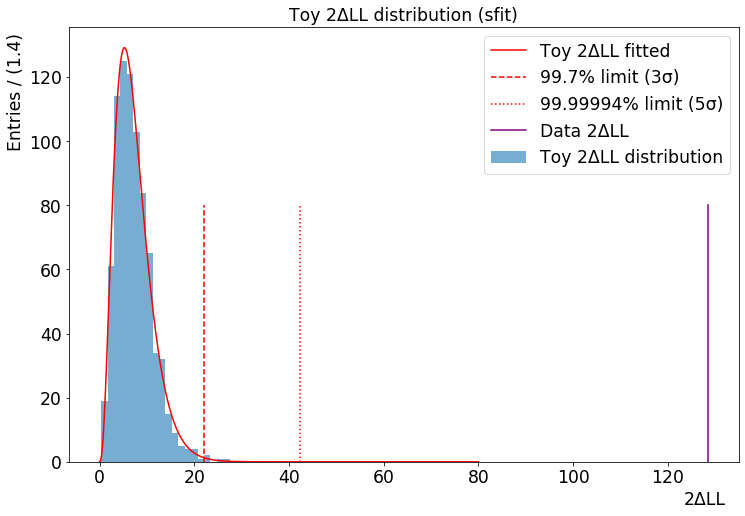

Significance:  10.202924904324114


In [6]:
# the array of 2NLL (edit here)
d2NLLlist = 2*np.array([2.8376747548891217, 3.3215324387410874, 2.1967258907752694, 2.7759924374386173, 5.727849334160055, 3.4448505144482624, 3.1827806807441448, 2.9852573086945995, 3.158253039032388, 4.205353529077911, 2.386912512971321, 5.461722873455983, 4.0696233797580135, 3.1148919682691485, 3.5081425784856037, 2.6984193152320586, 2.425267814064682, 3.0741524056975322, 3.138008691524192, 5.538949799326474, 1.929235492090811, 2.786256550351027, 1.2556503157456973, 1.7105583849315735, 3.83826770234009, 3.688608231159378, 6.36604574994908, 2.8577046282143783, 0.7246009173595667, 4.658179074480358, 1.2798573768959614, 5.293747509967943, 7.785286690595058, 5.045400195579532, 11.375302626045595, 3.781037032614222, 2.425980789793357, 3.908252890645599, 3.0034731395253402, 1.3088856989470514, 4.879189883060462, 2.883688641433764, 3.5460040113830473, 3.00464033848948, 3.2793780754673207, 2.224884863187981, 0.3226500445889542, 3.2406275956573154, 5.065868813103407, 4.982311135735472, 2.1254889911488135, 3.0814417917972605, 6.905437958308539, 3.5183716472738524, 1.1033809707960245, 1.8298145965000003, 4.297564832870194, 3.272289612199529, 9.688108319345702, 2.5892592488753507, 3.499449555751198, 8.685461444541033, 3.2246238336429087, 2.8636209999331186, 3.2023205076102386, 2.5941174624867926, 4.927108094469077, 2.0117419615962717, 1.75950801298859, 2.393656298921087, 4.79668077972201, 4.035358998219635, 2.8698955229901912, 6.882938315198771, 4.682909716180802, 4.374893372547376, 2.9679825136363434, 0.17963199040696054, 4.566261025086533, 2.059908689693657, 2.590422845980356, 4.958521068456321, 1.7086296716825018, 3.6251233736129507, 5.180827889867942, 4.0258974897496955, 3.2331729428187828, 4.3277614362423265, 3.3249751780840597, 0.8820628876164847, 2.4465318529710203, 3.7450826028489246, 0.8286907649517161, 3.6143666719490284, 3.342091430316941, 3.7022648503134405, 6.185226361039895, 2.7504971839916834, 1.0783627274740866, 3.34160970324956, 6.902220410220252, 1.3345274238918137, 4.640371952958958, 3.6060938007012737, 1.8778201602408444, 7.8020311484924605, 1.1212962433355642, 4.5246064943494275, 3.928224378330924, 2.748250840221772, 6.216466244199182, 5.1597769397594675, 1.987095220511037, 2.31113082378306, 1.9780339133967573, 2.566641751818679, 4.7697037518437355, 3.752617219730382, 5.856117132698273, 3.019645575986033, 5.685891899885064, 5.144497597752888, 10.643426689402077, 1.2724260071900062, 6.046165270674464, 6.365065226953448, 4.873316183957286, 6.964758332126621, 3.3515463896401343, 3.574561780730619, 4.966798757830475, 4.411896419684126, 3.2302887770383677, 5.3115943344437255, 2.9957846928346044, 8.101132578605757, 2.6352104920661077, 3.1465423002900934, 4.15487914829464, 3.645966398863493, 1.2055073705378163, 2.1939647448871256, 1.1516646663394567, 3.923520144324357, 12.380675416125086, 2.7348935096579226, 2.8589568374836745, 6.3556074714342685, 3.626166472130535, 7.3887002553256025, 3.1500057520843256, 1.3485208709316794, 3.06818583878794, 4.47162152056535, 5.289867671450338, 3.311032944611725, 1.0893353278524955, 5.662934861029498, 1.1849523191449407, 1.3536872088088785, 6.113319714707359, 3.223711366590578, 0.7549987908132607, 3.617722653802957, 2.369447387107357, 3.8052482865186903, 3.185769149794396, 2.0742642380400866, 3.6826423843758676, 4.915812675134475, 1.1214858114781237, 4.614051739080423, 7.226039064240467, 3.3335867659952783, 4.946813643430687, 3.1598843235024106, 6.360315521120356, 2.3529887082349887, 7.772398683430765, 6.569526638450952, 2.358294990788636, 3.2786691305700515, 2.3108614805150864, 5.067814121555784, 3.9173855177059522, 2.2853205846358833, 5.6258532785423085, 2.9788246847183473, 2.0396496913699593, 6.229492138738351, 2.6091639436817786, 3.0296664647712532, 1.9371982339926035, 3.2724341461753284, 2.607768291197317, 5.11466316352562, 1.2430886071397254, 4.318565763389415, 4.812945744086392, 6.920746606412649, 4.192418002435261, 3.346275863761548, 2.242399152492908, 2.0857372111922814, 2.2085141460893283, 0.9879880937060079, 1.9100069324595097, 1.7215227643837352, 4.425570859646541, 2.3606529904236595, 4.177644700454039, 1.8849572527460623, 2.8993973519627616, 3.0497449197364404, 4.259718740563585, 4.608234357647234, 2.5578344378927795, 3.0376238729204488, 0.6189105789026144, 3.695468238003741, 4.882048725077766, 1.5641628460880383, 1.1043976290711726, 1.2219479973509806, 4.9743674669780376, 4.320746908850197, 2.9944631757825846, 13.735838201130719, 6.951662851217407, 1.4102312506247472, 3.2819637532484194, 5.578902931521952, 3.347305961168786, 4.002063473646558, 2.516168800766536, 2.5213364742085105, 5.028753864487044, 2.1578717069060076, 5.494601282450276, 2.5976097615248364, 1.9107684099790276, 1.60492249302024, 4.6294035196406185, 2.3200488261800274, 1.0288493217058203, 3.380152435393029, 3.8409249421374625, 3.453104933146278, 2.2144071210295806, 3.508291438853121, 1.487030900042555, 2.1077434776516384, 2.4285135271729814, 8.625235673442148, 6.068379028921299, 6.076395447287723, 4.337398697597564, 5.0319807356563615, 4.220469587891785, 4.7517697101138765, 8.750202285914384, 11.118645968345845, 4.904236718730317, 4.334714157812414, 1.8861870533964975, 2.4111249470897747, 1.2920150419622587, 2.39094361457137, 3.955570171940053, 2.974699682132268, 1.728160381779162, 1.2621194173407275, 6.136107310727311, 4.2564234999299515, 0.9557817639779387, 6.088918455568091, 5.49860471149259, 2.1061108011199394, 4.678061084798173, 6.300179360843686, 3.7613797660515047, 1.610047715712426, 0.5012960588801434, 4.084452470368888, 7.052559675769771, 5.571025030136298, 5.606286162069409, 6.256103780593548, 1.6331579401885392, 2.1573205221520766, 3.102955930326061, 2.4671505432424965, 2.3497756272417973, 0.6059080110580908, 1.3485426125480444, 4.028646006795498, 4.15258620172699, 4.675869958705334, 7.020131362569373, 1.5189589129040542, 5.15116658657189, 3.749803959145538, 2.870644173844994, 6.109896025282069, 3.9092147366445715, 5.314087339197613, 2.9025683301624667, 2.413834646518808, 4.71190720044433, 2.6533535616717927, 1.9950721169561803, 5.042062725819051, 6.5955590491412295, 2.974752817510307, 2.721081314537514, 2.569329127705714, 2.844207639231172, 8.033670663351586, 2.275106154790592, 3.1629416321966346, 1.608299315322256, 3.228426668974862, 0.2451760090789321, 6.428925440755847, 5.632558141774098, 2.6566943856341823, 2.205054169102368, 1.5420747353455226, 3.5496595847134813, 0.6331867180742847, 1.1565052458781793, 3.916507083043143, 2.9250787768332884, 4.4284328041303525, 2.0306307860264496, 1.0067068311736875, 4.724814503759262, 2.8093211291161424, 4.6984558178446605, 8.646124352131665, 5.173048159773316, 1.0243597294374922, 4.091065624606927, 3.0838791027690604, 3.9068120019592243, 2.6078311515675523, 2.6030802832565314, 3.333022699966932, 4.943731974934053, 3.3588816604396925, 1.8264519400436257, 4.544025790510204, 3.3223915343560293, 3.6776847000974158, 1.3317181658840127, 9.028945020565516, 1.0209343600381544, 4.451564429300561, 1.9284637070513782, 6.575675051311919, 4.951745370308345, 0.6962465051092295, 2.896019770299972, 7.0794390617293175, 4.548177323486925, 3.088297746338867, 8.133767569264819, 9.485875895410572, 4.9363717413771155, 2.098798585878285, 3.6191844324703197, 3.475882641784665, 4.844288747660357, 1.8079727024960448, 2.9382773885317874, 3.7631336333561194, 4.617861480041029, 2.2511244378565607, 4.409640581114218, 7.311779747479704, 1.164208180202877, 2.3656018947222037, 1.5398215595350848, 6.411449197048569, 4.238074842785863, 1.7006959164100408, 5.072593189526742, 5.937184091450035, 0.9789581571303643, 3.4048995594112057, 2.9122084687433016, 1.9622186836168112, 2.9968464891571784, 3.0074886613174385, 3.1653252005453396, 5.935138527246636, 4.83816518009553, 2.8930472336696766, 2.2044039102474926, 7.422741165137268, 1.6337268905790552, 4.481171522705154, 3.7960000652183226, 3.6883241412460848, 2.6649518822177924, 1.7283668158070213, 2.270417072334567, 3.196589863484405, 1.3360296885402931, 2.2804583964316407, 1.8975642286368384, 5.368948975919011, 2.3428489371362957, 3.777973867464425, 4.4881249715954254, 2.6724298251074288, 2.9222854417830604, 6.295922283357868, 2.1454084883826, 2.953659574303856, 6.399896549140067, 2.6416469156811218, 1.701424845157817, 6.763235760415228, 1.9157632016604111, 2.4807730177617486, 2.7116497433307813, 5.785656151946569, 3.5106875568544638, 2.1749318627553293, 1.96319373795086, 4.717930482128395, 4.394071553535468, 3.2473242119485803, 4.612612195331167, 4.549882111265106, 2.8123945413999536, 3.338146705710642, 4.865734235281707, 5.7908132864686195, 3.78396520170827, 0.8101576053686586, 3.0602868830983425, 3.724204316817122, 5.109584421193176, 3.9526810467868927, 3.2191065775969037, 6.6286639093250415, 4.844134090206353, 1.3614074695469753, 2.485055661100887, 9.879846553063544, 5.45194422728764, 3.4526146663592954, 10.054615680626739, 3.0513384339974436, 2.8333977206029886, 6.023740155353153, 5.013684480496522, 5.200665541438866, 2.236140027793226, 2.3924244529953285, 2.732188626419884, 3.1856607084955613, 5.399414497078396, 4.007901588716777, 2.640986099775546, 1.4180737693504852, 3.642352658481286, 3.68394599135263, 2.234609346027355, 1.8520026776122904, 2.247697710511602, 4.515684604579292, 3.1353923067572396, 1.8068877634623277, 2.619961551270535, 2.398920553010612, 4.902085088710919, 2.195405352807029, 1.6748228600918083, 3.6216338115564213, 2.6391116210852488, 3.658037563753169, 2.773101116304133, 1.3280640375542134, 5.314842321075957, 2.3902416174296377, 6.317327014894545, 2.623622726816393, 2.185793823210588, 2.825476453985175, 1.1873322025639936, 9.247691067716005, 6.4540084450845825, 4.949807373386648, 3.081346973649488, 4.222023880673078, 6.279844045727259, 3.0314349559193943, 5.577283253392125, 5.304695373783943, 1.876203997830089, 4.481244615148171, 3.6777573088247664, 4.197082627157215, 2.479787129612305, 2.219715465803347, 2.9000459474964373, 1.9025399658930837, 4.499932964506115, 3.24116084364141, 4.039938507177794, 0.6594162601313656, 3.874515070439884, 4.425904681438624, 6.935092053988228, 1.512513970942564, 2.944579517103193, 1.166056854247472, 3.363465894231922, 4.73619835547197, 1.1323371787211727, 2.143728088025455, 2.8860239765090228, 7.092020657719331, 3.602964383680046, 1.7593465696518251, 4.343997165117798, 9.728775361697444, 4.565726803916732, 5.965525351100041, 2.8801138933285984, 1.8024443676013107, 2.5681801158871167, 4.94757116778419, 2.819246068343091, 1.90061428131321, 3.206721885314437, 4.43880847688979, 2.0329245146485846, 4.270869915750154, 2.5107290463201934, 2.3088580121657287, 5.405089103812315, 2.7470192741866413, 3.304109553773742, 2.656835446515288, 5.9195447044157845, 4.946357760883984, 1.1958481644205676, 3.627123613274307, 3.8486570975564973, 1.7170564300649858, 2.912168360781834, 3.406640718239032, 1.9648121379113945, 2.878028848449503, 1.5360842158897867, 2.6359169297302287, 2.5147164565696585, 4.421226238694544, 5.216222771317916, 4.530926181375435, 4.927383395319339, 4.265059541397932, 3.3066383208551997, 3.263833931722729, 1.6089820700199198, 5.537000754442488, 5.3475842896114045, 3.2860418558484525, 4.955906296634566, 1.3601591522892704, 2.1014040904383364, 6.793639011211781, 9.034546548057733, 2.63930936590441, 0.7244223757206782, 4.80967754426274, 4.489787219465143, 2.284538768962193, 1.7811741896466629, 1.6261327176398481, 6.286679052233012, 1.5314383773857116, 0.9368333392758359, 3.6094527939503678, 6.797412167108632, 3.0550696363397947, 2.9950274862385413, 5.794671594670035, 1.4883841546470649, 7.776785419895532, 4.013998881193402, 3.758247611183833, 5.996324919244216, 4.328507820942832, 3.6997351445306776, 5.794976182413848, 1.5443579889688408, 2.079932902350265, 5.553599248020873, 1.780597007867982, 3.1085150583267023, 3.407125920677572, 2.466230529593304, 2.0547958334200302, 7.676664373716449, 2.907531449806811, 1.7019947883845816, 4.211037373064755, 3.845811321029032, 1.463303937857745, 2.7740223864939253, 3.7253173432400217, 7.0731414277624935, 1.9078841389509762, 0.6911313961536507, 5.0443223927914005, 3.5121066272968164, 2.616099214924361, 3.0698403389542364, 4.969075365125718, 1.3101436321121582, 5.0094809779157, 5.351055794015338, 7.564117070050997, 2.4941198200485815, 7.284882566015767, 2.7887940187301865, 1.2793557626118854, 3.2391538193023734, 4.793773382669315, 2.5383705894191735, 4.639107939743553, 0.8462789072691521, 2.7403896483092467, 6.886175909003214, 2.961875539735047, 2.2105490838685, 5.29755715234478, 2.432414173714278, 4.609379854353392, 1.848504017583764, 3.120235337523809, 1.9701977933582384, 4.29354477916786, 3.294910185525623, 2.6011176902948137, 2.793237919710009, 4.865374836199408, 2.1903774519696526, 3.0002308021776116, 6.4474622304223885, 3.6313126110562735, 5.914185136805827, 5.121787926731486, 0.8120299972852081, 3.5911573349603714, 4.729979807127165, 3.5949631931216572, 2.114145350369654, 3.647024614069778, 1.916978835946793, 1.8872316405868332, 4.196418175726649, 4.351420186331779, 1.5109323898677758, 4.106634611604022, 3.320107731643475, 5.544343216643028, 2.3040662582479854, 3.1046003291721718, 3.3235029147354, 2.027781448314272, 1.9396010295695305, 6.086192054872299, 3.6987162977438857, 4.378386008810594, 1.71547109453968, 8.576083973667664, 6.304654396584738, 2.258584854185756, 4.213119634649956, 1.45595099365255, 6.404103290855346, 2.5876837759687987, 2.5588035679120367, 2.7235352459692876, 3.745981586520429, 2.274421713805168, 4.785519521070455, 7.2639222797624825, 4.568488774219077, 3.4943764560930504, 3.5360144933520132, 5.5814668066796, 5.406071605367288, 3.843656831068074, 2.5622317667321113, 2.2479972489654756, 4.2758824634784105, 1.7958503775635108, 3.8455376651463666, 0.6981992590135633, 2.8584420978331764, 3.619622813203023, 3.6376987479516174, 4.460835433214925, 1.7386206225392016, 3.93984172065484, 2.8979717561014695, 3.6004140460081544, 2.1108114509042935, 2.878450410311416, 4.150942143645807, 1.1331115552075062, 1.6000380676950954, 0.9894656975657199, 1.7942908994318714, 2.2343316449978374, 2.4649698881048607, 1.5242630042985184, 6.126489813880653, 3.8566176765225464, 1.985318784662013, 3.7932735923077416, 2.0004105686839466, 5.033133323217044, 0.8414313744251558, 1.4682674619070895, 6.9643967153515405, 1.3336038724519312, 3.9756763148034224, 5.339378677881541, 4.515253922478223, 3.626067681357199, 1.4896024842619227, 2.3517887710131617, 2.4252085829048156, 1.9517431976701118, 3.41104225908839, 2.2101160333022563, 5.277510125169101, 1.089783496227028, 2.514374964599483, 4.518468944530468, 4.669421868616155, 1.5066873952746391, 3.17728014221575, 3.6957832216921815, 7.3699662620510935, 3.8935229659618926, 4.937282989221785, 4.034101781026038, 1.9487752539316716, 2.177085150791754, 5.635515505136027, 4.894486622262775, 3.651376921694464, 5.7667008259522845, 3.0690740981135605, 2.5479184429805173, 4.917463668461096, 2.04242385094949, 2.356736759175874, 3.963588275732036, 4.4040026663224126, 1.5590738969194717, 2.3053820955383344, 1.8133100579807433, 6.541082103489316, 2.186464067687666, 2.0960157169320155, 3.8338795006193322, 2.1956276365963276, 5.344122566490114, 2.1079961980522057, 2.3989947380978265, 2.0404003738076426, 3.3370341540421578, 3.7337785541694757, 3.0520569998225255, 1.8521075960888993, 7.717282929175781, 3.795985137804564, 6.521407429638202, 3.654693469360609, 6.762027779321215, 4.244514637142856, 1.596314427388279, 1.9097100231811055, 2.181214120547338, 3.8829588004709876, 1.7308861189121671, 4.027054182818574, 4.086203756392933, 2.12511297499168, 1.7575277867408658])
mode = "sfit" # sfit or cfit (edit here)
Ndata = len(d2NLLlist)
print("Sample amount:", Ndata)
df, loc, scale = stats.chi2.fit(d2NLLlist,floc=0)#,fscale=1)
print("##### Fitting with scipy.stats.chi2.fit")
print(f"df={df}\tloc={loc}\tscale={scale}")
print("##### Fitting with iminuit")
msc = fitChi2scHist(d2NLLlist, stats.chi2.pdf)
print(msc.get_param_states())
#df = msc.values["df"]; loc=0; scale=msc.values["scale"]
print("##### When fixing scale (which is used in the plot)")
m = fitChi2Hist(d2NLLlist, stats.chi2.pdf)
print(m.get_param_states())
df = m.values["df"]; loc=0; scale=1
Nbins = 20 # number of bins (edit here)
plt.figure(figsize=[12,8])
_, bins, _ = plt.hist(d2NLLlist, bins=Nbins, alpha=0.6, label="Toy 2ΔLL distribution")
binwidth = np.mean(bins[1:]-bins[:-1])
xx = np.linspace(0,80,500) # x range of overlaid chi2 curve (edit here)
plt.plot(xx, Ndata*binwidth*stats.chi2.pdf(xx,df=df,loc=loc,scale=scale),'r', label="Toy 2ΔLL fitted")
d2NLLs = 2*abs(5644.694640528193-5708.949803140256) # Δ2NLL from real data sfit (edit here)
d2NLLc = 2*abs(6195.48532568372-6260.795249989678) # Δ2NLL from real data cfit (edit here)
if mode == "sfit":
    d2NLL = d2NLLs
elif mode == "cfit":
    d2NLL = d2NLLc
stick_height = 80 # the height of vertical bars in the plot (edit here)
plt.plot(np.ones(2)*stats.chi2.ppf(0.997,df=df,loc=loc,scale=scale),np.linspace(0,stick_height,2),'r--', label="99.7% limit (3σ)")
plt.plot(np.ones(2)*stats.chi2.ppf(0.9999994,df=df,loc=loc,scale=scale),np.linspace(0,stick_height,2),'r:', label="99.99994% limit (5σ)")
plt.plot(np.ones(2)*d2NLL,np.linspace(0,stick_height,2),'purple', label="Data 2ΔLL")
plt.legend(fontsize='xx-large')
plt.xlabel("2ΔLL", fontsize='xx-large', position=[0.95,0])
plt.ylabel("Entries / ({:.2})".format(binwidth), fontsize='xx-large', position=[0,0.85])
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title(f"Toy 2ΔLL distribution ({mode})", fontsize='xx-large')
plt.savefig(f"/Users/lyret/Desktop/temp/DDspi_latexfigs/sigtestZ0_{mode}.pdf") # save path (edit here)
plt.show()
print("Significance: ", -stats.norm.ppf(stats.chi2.sf(d2NLL,df=df,loc=loc,scale=scale)/2))

$Z_1$ significance test. Very similar to that of $Z_0$

Sample amount: 713
##### Fitting with scipy.stats.chi2.fit
df=6.480403089822823	loc=0	scale=1.3604523679755314
##### Fitting with iminuit
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | df    |    6.5    |    0.3    |            |            |         |         |       |
| 1 | scale |   1.36    |   0.07    |            |            |         |         |       |
-------------------------------------------------------------------------------------------
##### When fixing scale (which is used in the plot)
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------

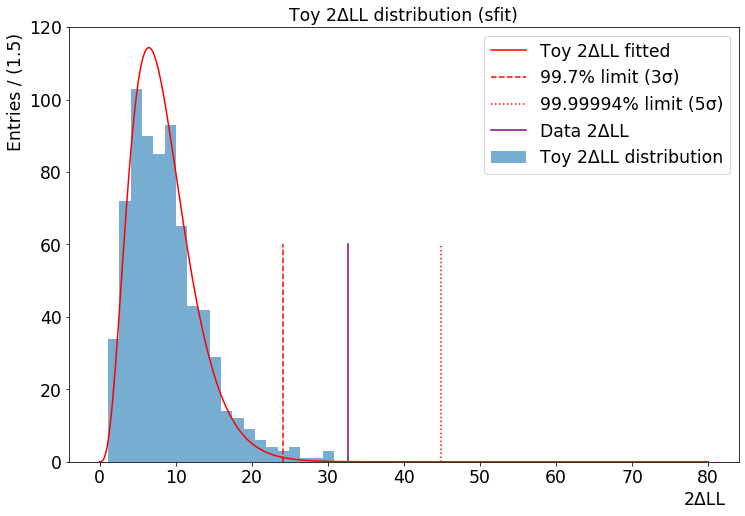

Significance:  3.8875025193074433


In [7]:
# the array of 2NLL (edit here)
d2NLLlist = 2*np.array([2.207616932961173, 3.906227528270392, 8.482715398847176, 6.620228331781618, 2.601021855066392, 4.323491028905664, 8.423345930606047, 5.1405694395934916, 5.915917212309068, 11.339458512949022, 2.5526179831613263, 1.76237302512709, 7.236656367169417, 2.6238559227595033, 4.136605904037424, 3.4504769887162183, 7.137464291861761, 5.310145341923089, 4.057507014797011, 1.8881132355645605, 3.629709632925369, 5.360803711093467, 9.082846344939753, 0.6294497377366497, 2.8663249345081567, 6.595547984635232, 4.310317670832774, 1.4701149362927026, 4.34680260136156, 3.7682441334818577, 7.154358257470449, 2.6839723583216255, 4.028783724821551, 7.544937331253095, 6.297971143882023, 3.497422195316176, 7.165790145843857, 4.4906389896732435, 2.8581015079662393, 4.864264598334557, 3.767358604578476, 0.7734563532503671, 1.4065463499164252, 4.524039407032433, 3.0847829089580046, 2.7029824524197466, 4.295369347447377, 4.729758388866685, 2.845988738734377, 6.6109380313182555, 0.6365889563985547, 4.27467084348973, 1.5172604472918465, 6.827135658981206, 1.39696903008371, 4.169627042027059, 5.925271479692128, 5.6360447791994375, 8.825643309583938, 3.539794501140932, 4.711679111473131, 7.638497581039701, 3.059706392113185, 6.415939397496913, 5.495709390601405, 4.852978007087586, 4.276763301259052, 4.751119773332903, 9.659053433775625, 4.9999401959048555, 2.9121033096826068, 4.603913607827053, 3.40611267195618, 9.668991310357342, 4.449375616493853, 2.8313431432461584, 12.781852932387665, 3.6716932186554914, 7.362690535380352, 3.4505623884788292, 5.807609340347881, 3.2477360194443463, 6.624939070837172, 4.703455051514538, 1.352202213023702, 4.241786017204504, 6.222239833016829, 2.080306051019761, 5.871278021866601, 1.1774470692998875, 2.313142741772026, 4.716557733792797, 10.588490821787673, 2.9373524188104057, 5.034683710116951, 2.323305156002789, 2.2127728029436184, 2.170165919840656, 3.5376222885060997, 2.356523007800206, 9.440806152788355, 2.4130601961333014, 3.237706779882501, 2.5682223145759053, 5.9815775378820035, 3.251549904673084, 4.489123332851705, 10.015461851195141, 8.057936792785767, 1.0369692112044504, 1.4756373371001246, 5.086081535288031, 3.8260657696901035, 2.9107298084663853, 0.8468396361040504, 2.5513966756889204, 4.576303079082209, 7.0031306419678, 9.896642935985255, 5.0225741800932155, 1.5719920765186544, 9.50386608550798, 3.7187493021556293, 3.9129578080573992, 1.1348476753773866, 3.3084974727007648, 8.017540145329804, 6.6444819256958, 2.617382201939108, 6.398475592181967, 10.268189832302596, 2.475219180601016, 3.501895687747492, 4.082989247921432, 3.3631231964527615, 7.3776956774945575, 2.63698045230376, 3.2746963760127983, 11.062547893705414, 1.693146525024531, 4.891259660604192, 3.0003544960836734, 4.660733562840505, 3.0381737554298525, 1.8219442169629474, 5.553789471001437, 5.555955342720154, 3.3533591921641346, 2.4301304666842043, 2.51876626486046, 3.6475985531569677, 5.051906136759499, 8.61871967258594, 10.328692271532418, 5.000880088684426, 1.2297313971512267, 4.907558096825596, 4.622298854299515, 8.504529663136054, 4.233110278612912, 3.465627982245678, 4.8235624621711395, 3.042034494442305, 2.4019776555724093, 15.409141046398872, 5.4845987206126665, 3.1599644064690438, 4.716431930428371, 1.2443461084021692, 4.95245821613571, 1.6304141968021213, 2.2662844796459467, 2.210387731046467, 2.421965974255727, 5.916942258551899, 3.4709888330971808, 2.3389264176339566, 2.9013605605032353, 2.8652439758989203, 7.289939640915691, 2.9850725121214055, 3.0347162003427, 0.9018002303491812, 2.9702449506330595, 3.2459292673047457, 3.9253704393622684, 6.625477104650599, 3.5385395677240012, 3.558072496017303, 3.3449720830985825, 7.029656604722732, 1.4311842184843044, 4.154202748535681, 5.429235149395026, 2.3354589744194527, 7.843687097409202, 3.4572552680665467, 2.3405534917701516, 5.917377443142868, 6.313059761138902, 3.760774678148664, 2.49815197046064, 1.4460195133115121, 4.230009450948273, 7.939086852335095, 4.605489966334062, 2.2477586082741254, 4.545545757684522, 2.8465334148695547, 1.5573232635279055, 5.296694685828697, 5.148517979339886, 5.579043895810173, 4.824395598339834, 4.543569780350481, 3.1347739682842075, 6.969069492743074, 4.45570921772196, 14.916293170552308, 1.9287964562299749, 1.5067651217150342, 1.629273481715245, 5.884575282131664, 2.676592412840364, 3.4692558785627625, 2.2352144242959184, 4.985644576020604, 4.012674556051024, 8.211963112666126, 6.559261734400934, 5.942283533047885, 5.051247506735308, 4.56107430418524, 1.7556945105134218, 2.6466665775142246, 6.444769130044733, 5.010261402027027, 2.893118262600183, 4.347553397912634, 3.805418173482394, 1.4821098165484727, 5.010932354918623, 7.6485410773611875, 1.7056805631673342, 3.84334956983912, 5.428322706051404, 1.829911083405932, 3.0734948831805013, 2.78876812607632, 0.9361902055579776, 4.829547059176548, 4.154984612463522, 1.1817889080812165, 1.1573089762341624, 7.235907619524369, 5.422346227817798, 2.6420951728305226, 5.608274667190017, 7.38156100595188, 2.3267460581810155, 1.1088227474574524, 3.856104583427623, 3.4352840154206206, 2.490589996879862, 2.2607708102186734, 2.8266907493034523, 1.460765563602763, 5.410976813161142, 1.9899545998814574, 2.385941223379632, 1.0421288906682094, 4.407898931978707, 3.8965769267470023, 4.0357469611408305, 8.173245963109366, 8.99949026970262, 1.447454620474673, 7.825260487781634, 4.077340982797978, 7.6349666014193645, 6.031709982459688, 5.29469757960851, 5.217100809247313, 2.225242192787846, 11.340952303487029, 2.9546259470916993, 5.451383883542803, 4.529316142360585, 1.7313417333516554, 3.6446823392325314, 3.522396862354981, 5.600238063845609, 3.6022943433272303, 0.6798109076753462, 7.669381235014953, 4.622880442695532, 2.9003692208525536, 1.6752503924726625, 2.193841880632135, 1.8093154386560855, 1.7373095391794777, 12.08083902744147, 2.7819376254683448, 1.4484298711031443, 6.493560371370222, 5.697826921155865, 6.5578451537076035, 0.5659653444890864, 4.3165995619528985, 1.7957399819515558, 1.143767528720673, 5.2236410812083705, 6.384332803750112, 6.82546883733994, 4.127806820213664, 7.325075931466927, 3.21433424551833, 3.5621378665518932, 1.9255938015203355, 6.312061722554063, 12.248416433411876, 4.742689409367813, 2.848941096006456, 5.181615186203999, 1.8403944969250006, 2.0785424799914836, 5.001685456491941, 2.6147733730849723, 5.840951285346819, 1.3819099703232496, 6.4204845426183965, 3.292111305432627, 5.82105874185072, 2.916628665272583, 3.38242164352323, 2.0730293933538633, 4.047188298356559, 6.802845906031507, 4.008220316339248, 1.668504171868335, 3.689800085555362, 4.792852979219788, 4.404971713375744, 5.173432985003274, 2.05755381277595, 2.049637255712696, 1.7214185550719776, 2.4807260373718236, 4.990340897529677, 2.7837683444931827, 3.9869948649502476, 5.22625138352123, 2.406155511590441, 2.4607580314686857, 4.647349008465426, 5.278321491192401, 2.2188896633124386, 6.251816496307583, 4.44062895873958, 5.35442739786231, 6.684742460826783, 6.37733306822156, 2.111893934014006, 6.714858744171579, 5.993517725222773, 14.35406047941342, 5.088890727459329, 5.1800692767492365, 4.387440610461454, 3.386997477598925, 5.477273415385753, 5.711918101334049, 4.3951458117862785, 4.188045325502571, 2.1479463220312027, 2.664706746205411, 3.953299387128027, 0.947177124045993, 2.7392086766049033, 5.809867115145607, 2.7526651444204617, 3.920158715565776, 4.318006405878805, 2.8003954189189244, 7.036836333309111, 1.6399308123200171, 2.775572830936653, 13.129708937529358, 4.721606207361219, 4.677638375907009, 7.388421156048935, 1.5010915007060248, 2.6059459283942488, 3.5778635795877562, 0.6210087253639358, 2.0930553981761477, 4.649671573549313, 2.7661077201601074, 4.758926673915994, 1.72546559598959, 6.808654551211475, 7.725518105581614, 3.773312518711464, 2.0744702410720492, 2.3219456105880454, 2.96390920664453, 8.193905710261788, 8.145803102385798, 7.122718878636078, 3.71930775419969, 2.6769011713204236, 3.940170031537491, 5.78221369836956, 5.045413550683406, 3.9453178771300372, 2.2130273522097923, 8.923302434547622, 2.0963469364915, 3.712338408186042, 11.046663768406688, 4.08279881442013, 6.0506057292532205, 1.3083933033085486, 9.841041316867631, 6.594116553786989, 3.0154019474484812, 4.7076563899181565, 4.7131327113611405, 3.70171984989247, 3.047227950683009, 3.8207324117975077, 3.668354663785067, 5.5332713262014295, 1.757758634226775, 4.229025477774485, 10.643061013396618, 4.846764219040779, 7.96030041623635, 2.710263326178392, 5.488788167213897, 3.8652592786338573, 6.72385420194405, 5.593331074227535, 6.916997910113423, 7.141745631004596, 3.0941579091795575, 2.9627762765203443, 5.324666710666861, 4.704330413926073, 2.892209186875334, 2.6188181107499986, 4.607345576411717, 9.069758710695169, 6.0624554753812845, 2.1644188241361917, 1.4006218049826202, 2.046676894279699, 2.694131883884438, 1.9102455920956345, 2.1570365045963626, 6.21134504964084, 1.3487037500217411, 5.108108192078362, 7.376680974886767, 2.4847006979734942, 7.9551951135726995, 2.795846843190702, 4.843547802357534, 13.587580436083954, 4.00238570374313, 2.934298406029484, 3.874662739197447, 0.5961964519183311, 4.1801052905329925, 3.343980256235227, 2.372176481903807, 2.3077400663214576, 10.445098375692396, 4.054407169105616, 5.8155289490641735, 3.770911231298669, 8.467953351576398, 7.874236140460198, 6.772660646953227, 3.65489619262371, 5.199917514956724, 2.30884579231315, 2.111014032856474, 2.2552153013048155, 6.8785779236950475, 4.42508949988769, 3.2831998888150338, 7.313927580546988, 4.468997647165452, 9.196610247270655, 2.166622404154623, 3.3678184308491836, 1.4487470886106166, 2.4740425338086425, 3.122488179957145, 3.61281094557944, 6.567252484574965, 4.044246473167732, 2.341634248923583, 7.072844330577027, 3.393160643900046, 5.288377995195333, 2.2825208388494502, 8.280330390452036, 2.0180909020964464, 3.805928265073817, 2.883393141320994, 4.416524620548444, 5.078232007351289, 1.1209572574562117, 5.587191451259059, 7.611584805848906, 7.013252726419523, 0.8760861882792597, 1.398149573511546, 1.0837237728810578, 6.438094349004132, 5.583968249633472, 1.8157188856075663, 1.4952792210151529, 5.2281034034740514, 4.2293194224057515, 7.595025912842175, 6.915800969953125, 0.9353942564293902, 4.418677185242814, 7.349471095215449, 5.851093639967075, 2.5622447980813376, 4.239062985012424, 5.905678451627864, 4.530267965084022, 2.0358689236991268, 3.2728167697405297, 1.6452299545762799, 4.304288283911774, 2.337582162810577, 1.5773611808708665, 7.84808208746017, 2.427044730414309, 1.9023188195942566, 1.6222757779869426, 1.609381830115126, 6.6812839521981005, 6.798906337782682, 3.1271255575093164, 2.447062372234541, 10.43113101518611, 6.752955294657113, 7.255592878197604, 10.09805559391225, 2.5400257793244236, 8.7622918589459, 3.4690050125200287, 2.8221882667494356, 4.885575635579698, 4.21749001812077, 2.7322945328205606, 0.9477873139603616, 3.391991116301142, 2.616773906157505, 2.905824117204247, 5.183657153887907, 4.65802844940572, 5.156700104690572, 4.920973785519891, 5.431865515702157, 2.898703053256213, 5.196426455309847, 1.4152625355509372, 8.742744601074264, 4.253802842295954, 3.1038110801073344, 3.9212028128822567, 1.9208780324534018, 2.440331748512108, 5.8035017552247155, 4.361269181368698, 5.421187592947717, 1.1363137067473872, 5.78967721407389, 4.645118871016166, 2.2912274948948834, 4.592224637779509, 4.889370622389833, 5.150128991444944, 12.140160286832725, 5.383410167642978, 8.292920165377836, 0.6573222154856921, 4.348693838865074, 4.581728681798268, 3.0643590095469335, 4.000178353029696, 1.9677628840663601, 1.9406579625301674, 4.5301084134207485, 3.6685441095796705, 4.773016351613478, 8.688272127199525, 4.0547455308478675, 5.329845419892081, 4.398399808155773, 3.5130982671780657, 3.1575633498050593, 4.040040109333859, 2.490486018237789, 4.643802832048095, 12.471980723937122, 5.01572131820285, 5.394106799862129, 3.6111647579082273, 2.734914844274499, 7.342153585710548, 2.4814515282560023, 1.3158268030474574, 3.168398612353485, 2.576720131073671, 3.3794321094410407, 9.646851737051293, 5.9820538603398745, 3.2460202077545546, 8.835620869809645, 2.1178233012651617, 9.734933619198273, 5.405565904712603, 0.851714966785039, 3.92420106408008, 6.061906890838145, 12.46981022896398, 9.092061194590315, 5.961588056856272, 2.026453216952177, 1.4219654457610886, 2.863934598934975, 4.086972696670273, 6.163939298261539, 1.2765669996688302, 3.1030115122566713, 7.743865343438301, 1.3541561139700207, 7.121279947724361, 3.715701935699144, 6.284721590734989, 2.1122360277304324, 1.493115838506128, 1.9896435880964418, 4.5021319160514395, 6.754772754959049, 2.76287025635429, 2.0232991775355913, 2.8078333916928386, 1.1582967946815188, 8.948587297812992, 2.064953137525663, 6.783256542653362, 5.006766189029804, 5.92096187721927, 4.551956699406219, 6.669290853299572, 2.241238498506391, 2.1836609818346915, 1.3889150804689052, 5.680776189960852, 2.914619588234018, 5.470065134562901, 2.6160330420498212, 1.8260526629519518, 4.664915555387779, 7.255693679014257, 3.3017326910176052, 4.224134153473642, 3.5462620764819803, 5.001641879312956, 5.676815987989357, 5.70710795375453, 5.425245068914592, 4.824412944668438, 4.488109799680387, 3.7364697658322257, 3.9691828579661887, 2.202656322287112, 4.226013083461112, 3.2790041010957793, 6.740850858931481, 2.300211872841828, 4.856595497643866, 4.38941751450875, 1.5103110209774968, 14.896336440274354, 4.867066256230828, 1.0790703277580178, 5.4963762922207025, 4.484357645264936, 3.2415347258393012, 3.7482172906220512, 2.324617945386308, 2.7928726865820863, 1.5040668690062375, 3.3090622796726166, 2.2927299637558463, 3.8715319220045785, 6.051704648989471, 5.2402697236921085, 1.1649259963069198, 3.2636220816348214, 7.357283882755837, 0.8472132789247553])
mode = "sfit" # edit here
Ndata = len(d2NLLlist)
print("Sample amount:", Ndata)
df, loc, scale = stats.chi2.fit(d2NLLlist,floc=0)#,fscale=1)
print("##### Fitting with scipy.stats.chi2.fit")
print(f"df={df}\tloc={loc}\tscale={scale}")
print("##### Fitting with iminuit")
msc = fitChi2scHist(d2NLLlist, stats.chi2.pdf)
print(msc.get_param_states())
#df = msc.values["df"]; loc=0; scale=msc.values["scale"]
print("##### When fixing scale (which is used in the plot)")
m = fitChi2Hist(d2NLLlist, stats.chi2.pdf)
print(m.get_param_states())
df = m.values["df"]; loc=0; scale=1
Nbins = 20 # number of bins (edit here)
plt.figure(figsize=[12,8])
_, bins, _ = plt.hist(d2NLLlist, bins=Nbins, alpha=0.6, label="Toy 2ΔLL distribution")
binwidth = np.mean(bins[1:]-bins[:-1])
xx = np.linspace(0,80,500) # x range of overlaid chi2 curve (edit here)
plt.plot(xx, Ndata*binwidth*stats.chi2.pdf(xx,df=df,loc=loc,scale=scale),'r', label="Toy 2ΔLL fitted")
d2NLLs = 2*abs(5725.300065909379-5708.949803140256) # Δ2NLL from real data sfit (edit here)
d2NLLc = 2*abs(6274.755635407866-6260.795249989678) # Δ2NLL from real data cfit (edit here)
if mode == "sfit":
    d2NLL = d2NLLs
elif mode == "cfit":
    d2NLL = d2NLLc
stick_height =60 # the height of vertical bars in the plot (edit here)
plt.plot(np.ones(2)*stats.chi2.ppf(0.997,df=df,loc=loc,scale=scale),np.linspace(0,stick_height,2),'r--', label="99.7% limit (3σ)")
plt.plot(np.ones(2)*stats.chi2.ppf(0.9999994,df=df,loc=loc,scale=scale),np.linspace(0,stick_height,2),'r:', label="99.99994% limit (5σ)")
plt.plot(np.ones(2)*d2NLL,np.linspace(0,stick_height,2),'purple', label="Data 2ΔLL")
plt.legend(fontsize='xx-large')
plt.xlabel("2ΔLL", fontsize='xx-large', position=[0.95,0])
plt.ylabel("Entries / ({:.2})".format(binwidth), fontsize='xx-large', position=[0,0.85])
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title(f"Toy 2ΔLL distribution ({mode})", fontsize='xx-large')
plt.savefig(f"/Users/lyret/Desktop/temp/DDspi_latexfigs//sigtestZ1_{mode}.pdf") # save path (edit here)
plt.show()
print("Significance: ", -stats.norm.ppf(stats.chi2.sf(d2NLL,df=df,loc=loc,scale=scale)/2))

### Spin analysis of 0+ over 1-
The arrays can also be obtained from the output of `spinana.py`.

Sample amount 0:400, 1:400


<Figure size 864x576 with 0 Axes>

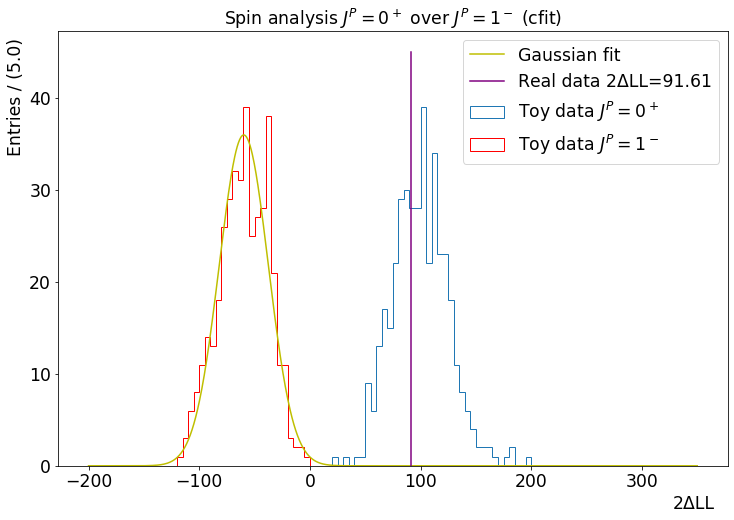

Significance:  6.817008552131246


In [8]:
mode = "cfit" # edit here
# the array of 2NLL (edit here)
'''d2NLLX0s = -2*np.array([
    -69.75987844390511, -61.885875018335355, -60.26961039044818, -28.22433792717584, -57.64248034905722, -42.2665610243821, -69.28484608781218, -50.05468350251158, -64.95862091765503, -59.661088588090024, -52.21204427098564, -44.03285430036158, -57.44279167216155, -44.22177850381104, -54.83789093908672, -60.84425310260758, -53.25756519452989, -54.62762690044747, -54.43488748431628, -47.184137639685105, -75.19800486286476, -43.3966513794976, -34.30347783614707, -41.39138155359797, -39.235396658682475, -32.55864759402357, -58.02904037017106, -56.72374198467696, -54.76467191936172, -51.95477768058845, -88.7327026347948, -65.06942624031035, -43.553159343038715, -57.98185266890323, -36.16413599106636, -55.742093615310296, -47.2237291938236, -63.48228060506699, -83.5251699172477, -42.83241026412361, -56.075864557345994, -53.383547226801966, -51.21889177500907, -38.340143096420434, -65.74740012970324, -83.31216785521246, -39.872580925574766, -47.17567010630137, -65.62620960904042, -65.14717955705692, -43.13293944582074, -45.16958875520868, -65.95649540151317, -40.38931744578804, -35.22685453425402, -60.84740392354615, -25.715566191088328, -60.98428494980453, -56.020711629098514, -71.04839186785557, -62.55827126564873, -43.09274876712152, -52.10287530435107, -38.32749910486564, -45.755960791566395, -52.59159052896484, -59.124299948394764, -56.118795127385056, -33.985662967606004, -42.426501434863894, -31.209959786501713, -33.408747989070434, -51.58426020760544, -61.012815492549635, -39.96612576829466, -55.55438158519155, -50.64618971533491, -72.39840527032811, -39.356717172623576, -33.82524475755599, -59.25908220398014, -72.43237457998839, -71.53790512406795, -69.12751951325481, -43.43772730511682, -87.63285350363549, -52.148032371955196, -47.77953972227897, -50.52003709273231, -48.9255709645131, -59.51076804851073, -65.25344666074125, -59.43726679134488, -61.43863312257599, -32.34006579392826, -50.51948000961693, -57.00411579073443, -52.05344478283041, -55.404078567849865, -51.85539655986122, -66.55982919320559, -64.29905659707583, -77.74951421893184, -47.44926851481796, -45.934277955552716, -16.126378597273288, -54.54326975757067, -59.09671698658531, -63.395155280595645, -52.65230500834696, -46.61797721558378, -56.63149109780079, -61.23021724364389, -59.84978246911487, -52.43449396145388, -40.326142050927956, -26.738181534592513, -57.71630802598702, -39.16161677845594, -38.52680779462207, -50.76541499801442, -40.05599936310227, -78.28430147000836, -62.369990224482535, -41.99543334073769, -78.6268510027212, -46.88952476521263, -55.1800719380135, -47.6114128758818, -56.84833593274743, -69.7251306669832, -61.693617023145634, -55.801920156497545, -83.04198079977778, -63.1948035057776, -68.47698125795068, -38.10134530531923, -41.63106606295696, -48.498046068052645, -59.01177957606251, -90.94534239291261, -33.9700871940222, -67.3578290137666, -31.46553014097117, -32.7916943402106, -60.05336922142669, -47.92990328969063, -58.4695034834258, -70.7369790839557, -64.4712333514799, -70.41144305859598, -56.5988568650655, -52.43181719187669, -49.97267628202735, -50.32241709783557, -51.845948447728006, -62.926745689963354, -73.93582738812802, -67.33259664366778, -54.19953285908923, -49.74651930815526, -38.28314038690496, -47.08070745960504, -44.87656867638634, -62.414424059924386, -64.2694157652495, -53.15868035669155, -65.73311801798081, -44.63348978912654, -66.94520798662325, -35.480588484428154, -39.93060957941543, -47.54133004505093, -46.42362072794731, -53.00163050889296, -40.08865859472371, -70.45308033481615, -42.139970963478845, -82.58687843298412, -47.937242519767096, -48.51096019125907, -48.53499968894175, -59.33312914750786, -51.38115798101262, -44.721289311609326, -38.753634715047156, -41.42891098685686, -57.520071304708836, -62.04608817602275, -59.37355420757194, -41.88650158028213, -39.413323402261085, -27.418337176195564, -62.67670115335659, -55.0692411099144, -45.979239841335584, -80.43049154588425, -55.35849612904349, -61.776340464866735, -48.22332647859639,
    -53.02166137498534, -46.99983902054282, -40.93026456114967, -59.678827138780434, -60.33575207893227, -70.18982386989865, -31.80561106497953, -67.387537536124, -49.120793703757954, -25.972203256952525, -38.94563901053334, -70.8561925821432, -43.513483191758496, -67.83541797127327, -56.40544238225448, -55.60095145060404, -55.17861818820256, -48.4414500115854, -57.06839770480019, -51.7075790284307, -55.01717318553165, -56.5842237565148, -42.75550910921265, -45.61203277226832, -59.56794295572672, -46.319328971851064, -62.69342206937472, -49.728704982419, -56.003103898548034, -42.785197864206566, -55.19834444258959, -64.72273522444539, -42.3076871869971, -63.20456283424028, -50.80458154935968, -55.53652696559584, -62.04938782133286, -63.24965048825834, -54.456672438818714, -68.92311756479467, -45.11805063579595, -37.450434670177856, -57.58836616602639, -52.13311880078436, -56.569405234355145, -42.14312252365198, -57.738521463846155, -62.492246488676756, -51.411868739993224, -53.723046688524846, -57.59486793395445, -48.295660739090636, -64.6580501794624, -55.07533058410172, -56.202602330129594, -42.66471630941214, -44.761277965444606, -72.4936926743494, -64.82883830871015, -33.71738891717905, -38.321127632447315, -66.50550396152357, -36.99952980350463, -39.938833073390924, -41.946842497738544, -53.49624222077637, -33.13563009666541, -40.96831792098419, -43.10278133890097, -36.70252651746523, -74.4745504074317, -49.54688003518277, -30.09570609892762, -59.75699799772701, -54.50270247539265, -50.26866891375903, -63.00014839604955, -64.5579609065644, -80.83444639084519, -59.698275776651826, -43.66356375165651, -44.40656969079828, -81.57970734388073, -47.81441356346659, -66.8457067721829, -51.20364906214854, -44.83864563457155, -46.80163927101148, -29.307425270078966, -51.69162167513787, -43.77109122321872, -35.74061124990567, -61.499368640250395, -45.433743792917994, -56.13411667598302, -45.3525265549506, -74.25215900099647, -46.105984127652846, -60.091580887962664, -43.14862462293149, -63.61503785252626, -64.18682343147157, -39.25749790183363, -52.49837153670978, -45.44827503404849, -47.61089136899591, -47.0772940733259, -52.224301907033805, -43.11759503722169, -42.35631924345671, -51.17208366645991, -42.285911724981815, -46.86902833128261, -58.8779302374096, -82.47570988695861, -79.86949616043967, -66.87905348734057, -59.587742854027965, -83.54380521027633, -56.26719707301345, -57.04322955344833, -46.480687995268454, -41.232903752103994, -53.21553196147215, -77.52897011463301, -48.09942218428387, -37.47141823603124, -57.17873297143342, -54.62432105190146, -69.125751685885, -47.48675285754143, -33.45267418892945, -50.90182191739041, -57.03012429669798, -58.550172160816146, -47.82571149769956, -40.7172342438771, -50.645362790773106, -53.44154939249074, -65.24955418901209, -59.530657824024274, -39.81096957904265, -28.50012488296852, -56.950558426871794, -48.709882983189345, -38.20167856176704, -29.736047884627624, -60.8653545520765, -62.77091366375498, -49.518598574623866, -52.660259038046206, -62.74108509076177, -58.1438594244828, -53.870517364079205, -55.80415885189177, -43.71302376343374, -59.33637543300665, -63.44590314376546, -41.27984026265494, -64.22989174156646, -57.96110459973079, -54.399670315168805, -40.055928820604095, -50.18993101583874, -43.466486213046664, -58.24635736217533, -40.43189092286866, -49.849951691709066, -62.92780523349393, -68.26757333145724, -74.97343472995453, -62.248170385702906, -38.01831187534572, -53.680192668814016, -48.37100961089982, -61.12651133957024, -49.19602040777045, -42.5056299507296, -50.51723835308076, -41.00842023230507, -70.13360218170419, -67.76284243623832, -55.89141346015913, -59.67877748878254, -64.7622866214515, -42.87242335281189, -49.80309094819222, -76.51992694866385, -75.72052776506007, -47.58854802619135, -59.5012026189097, -38.530441738625086, -79.38625928586589, -53.707025383808286, -24.822269083175343, -65.06084095787173, -22.578021558585533, -37.94746698592371, -61.52369755687687, -76.161146206573,
])
d2NLLX1s = 2*np.array([
    -25.457922775425686, -44.610119867606045, -31.570908988923293, -28.082313334680293, -48.403435954348424, -36.226019401772646, -32.45298524433019, -22.050289173746933, -47.97309392837633, -24.439578942239677, -38.721295769172684, -33.6479013194039, -45.105964568120726, -57.0686896643947, -45.15028346897907, -36.81836419230967, -45.51089960943955, -23.30696905795594, -29.893398013346996, -34.750118170458336, -17.670225370151456, -40.53771278375734, -22.828634831385898, -38.35198802949526, -41.78593996509153, -39.88884765331386, -24.46506461574245, -44.494564965672, -45.88352254686288, -42.97993177839999, -39.438675851315566, -20.529034090888672, -59.7845002577742, -35.34040017984353, -44.525344342295284, -27.48883305117488, -40.8194881921454, -32.28929191832776, -38.829352712404216, -50.975164614779715, -22.13928714285794, -36.399239235685855, -57.87583177020679, -36.020048129435054, -65.91323721857589, -31.503399940342206, -28.885521488531595, -35.66338416987492, -33.75312083681638, -36.53898960311744, -31.252939024665466, -30.32403757571865, -34.265872185732405, -34.72708852955748, -46.76175847468676, -32.941366598797686, -28.57457096512917, -32.35231792601371, -21.118644000047425, -44.6112750233151, -37.667952084510944, -44.25679258501259, -23.104985952276365, -46.028749568315106, -48.358862346698515, -27.02563616358202, -21.017679387562566, -22.08303049619917, -55.168392523344664, -58.03001690576366, -51.40155385008529, -45.63417260246206, -36.622985495457215, -18.93943369401677, -25.780320901742016, -27.644273421085018, -49.014064690102714, -30.662889146718953, -29.958211464549095, -11.707748991396329, -43.728378708462515, -26.59471363682951, -39.10780074952072, -24.556681289821427, -32.15685321014189, -33.20757937653161, -31.990592383766852, -43.101586172802854, -37.03091536388911, -39.88381543277683, -27.21614464819868, -24.444483703274273, -31.432074827909673, -15.431235839684632, -20.09327250647857, -23.047981449121835, -22.46320927433044, -30.87883308479195, -39.23396374773256, -59.01737645954836, -36.28575576964704, -26.88609104407351, -24.175949475211382, -32.69962582306471, -19.17909981127559, -23.580022766828733, -24.54907906129938, -24.328906314509368, -64.90121407856168, -52.48218191829619, -23.093132303872153, -31.8052384838129, -39.09990292501061, -31.94773337179322, -37.91833775861596, -27.69535680846093, -43.33492297898738, -45.31990927087918, -18.355825554722287, -38.18512139604081, -32.05101944026046, -41.55325723023725, -36.38962539100703, -37.40925264195357, -38.43343994429415, -32.11632017345801, -22.21224809150408, -24.32270746031918, -37.79295507583811, -20.81099825678848, -28.293081527656796, -23.951821385217045, -61.79186577272776, -35.92850796589482, -18.548703393699725, -26.17890250873461, -32.39079204853806, -35.552763143797165, -40.40662760094165, -26.733592353182758, -40.65164830021422, -43.21994274748067, -43.745076480000535, -39.58014050546262, -32.82647555537005, -29.63284791568185, -40.87847578056335, -57.37783948426841, -52.30754185746537, -57.382250038291204, -36.51362713607068, -16.723333616862874, -30.640186233480563, -30.080677298099545, -40.323147591628185, -24.69845000465375, -32.84339755018573, -32.15889542684636, -30.79168298649347, -43.027275135998025, -26.94875062589108, -28.390355228828412, -38.70343168116506, -68.65460875653662, -20.023299165592107, -33.59279325910575, -55.64517472071384, -46.57572347476889, -28.893313334870072, -39.37194723301218, -29.891322797804605, -51.488294217982, -54.255836947939315, -32.67536008031675, -54.847351686578804, -25.428650664742236, -36.80897959754839, -33.560043154846426, -46.28176037165031, -59.106675125853144, -45.50144954710868, -26.927330513984998, -42.73457294170748, -46.77302773615702, -32.244134220436536, -53.02846981588209, -24.370697784204822, -29.687234158492174, -37.49933564274761, -4.144649308221233, -21.105608229314385, -24.153433108861464, -29.981550434822566, -23.49675653198483, -48.428364829732345, -32.22115298355038, -40.4956392688855, -46.246995756145225, -42.83033803167655, -59.812005799500184,
    -23.603398354531237, -43.88003892996312, -27.05344778891049, -54.48434921755688, -23.403676156103757, -33.20295630338478, -54.43873317974976, -45.92628572727699, -29.04935866604319, -33.79955808178602, -35.293561737414166, -25.552451091394687, -26.032382562010753, -46.57351154130993, -34.859091784470365, -32.03677656344007, -27.123540679573125, -54.77250192658721, -33.81528293536667, -30.530246017074205, -59.199177830955705, -33.644173399379724, -41.49913876807841, -74.3549617306071, -3.591146288094933, -35.378361885408594, -57.52770821483591, -20.436680149957283, -52.0479588854314, -50.97391949942721, -24.8135587913539, -40.64533493709678, -22.892799583609303, -24.387565063968395, -34.720899865564206, -61.533558706970325, -35.60091377127719, -56.462195396035895, -39.94392050978331, -31.116001452188357, -26.392940418048056, -76.79146150425458, -28.209114397908706, -28.486398740797085, -45.103029722313295, -36.380239046317, -26.357956811255463, -39.106866803727826, -15.888266592404761, -36.38001789434202, -29.859021917913196, -21.18830252119278, -16.349367873443043, -41.98594880104065, -36.23384018213255, -33.99817006302874, -29.049190458566954, -19.12837256986768, -28.8533421776865, -21.755262213724563, -21.17874098009088, -33.080747291349326, -31.900674814350168, -27.31972594373201, -30.637849243743403, -36.319774488409166, -20.85464061307448, -27.348267611184383, -33.95847170158504, -32.557113153837236, -43.03246788343313, -46.59572778009715, -34.69685930223386, -44.2924860740568, -45.53103840197127, -8.973322059859129, -27.010862496850677, -82.76245591865336, -26.30343307732801, -65.50043918941265, -37.17621297038295, -24.31306002180827, -39.62120085801598, -22.413862616779625, -36.70557850195928, -45.664079170262085, -44.688593582724934, -50.04565003440803, -17.239333381503457, -37.93633310133191, -46.15141465776651, -36.05237501036845, -29.24331886073196, -24.172397294550137, -43.4692836641716, -47.02046590174905, -32.101543323913575, -41.964617146853016, -60.26484543452625, -16.233398984810265, -50.424662063906, -30.94563408567592, -30.199471612169873, -21.138684941182873, -33.75264102409983, -32.56684256161316, -41.52789593366833, -53.62061200363496, -43.84084738371348, -59.036795406598685, -46.280418714919506, -25.497704952087588, -42.18581259696839, -47.929324470555, -16.618290999772398, -47.48723983836953, -50.43551611057774, -58.38721973365409, -48.4073108729026, -32.85374713461715, -31.932103075171653, -50.67311589235214, -40.530998303480374, -30.32492418388574, -35.32587342369516, -60.87539431635105, -44.25456295113145, -20.189934687749883, -34.8890455015553, -20.662491483983104, -26.928468817095563, -29.511632180729976, -22.736159499982023, -28.111985646622998, -34.1390573470635, -31.066596161415873, -25.8042690894481, -37.150095905197304, -19.546694654278326, -40.21654364553433, -16.3961980649201, -40.339472448079505, -41.74496329057547, -52.09570401869314, -50.11002490721967, -52.72996938287815, -34.03650270462185, -43.9517638520374, -33.77406269868152, -11.625853092416946, -37.80668751925623, -32.63017802512604, -63.67197484756798, -56.15383302601367, -36.18552691909281, -41.79330996617318, -36.687944742084255, -40.58207788529762, -32.235433489476236, -66.69363696421533, -71.57153457908407, -36.91127430842698, -36.35242790680513, -53.21724420749433, -24.2071152746812, -27.857945904479493, -33.37676130766522, -39.51670575499975, -44.06308575335879, -53.49633310261561, -21.696839782403003, -45.29863463857055, -43.745246508981836, -37.27749144844529, -21.3222750752102, -48.108663426746716, -25.725875817889573, -57.63386153900046, -38.91654327625929, -32.30561317695265, -41.24832987085483, -30.90581236685557, -43.38487698875633, -73.99015488446548, -25.45625957237371, -23.845607190512055, -59.7838151856613, -43.51778367465704, -17.77895558704222, -24.885945284513582, -25.844729096938863, -48.108606782956485, -27.722387279029135, -28.12431825889962, -69.72360916732032, -25.37242327614149, -25.913702026111423, -24.14678351520797, -37.2636354432434, -32.176891040665396,
])'''
d2NLLX0c = -2*np.array([
    -63.59000820724032, -37.602619249083546, -72.12266754010398, -32.53590367127799, -54.288400205516155, -38.88733270540615, -61.79330501491131, -48.4201864750612, -66.96627299962711, -51.12527791987213, -55.31216951686292, -44.21743020222402, -25.32006241487943, -28.99582501613986, -61.25799032428404, -57.92368790394903, -53.92140567331808, -56.23749102991587, -50.134500092358394, -50.268986838357705, -33.953538397345255, -29.850498376480573, -32.16426944032082, -41.12680621509662, -40.57188094546382, -32.48913541382444, -57.12371831202563, -33.76322857465311, -58.90687683855322, -51.054239474668066, -90.03845028253727, -59.593084372698286, -43.77240837245881, -56.738077520374645, -35.5831213468482, -46.92527565205819, -50.6626204980239, -40.497282694565, -78.65536787723522, -47.6497637745224, -56.02374983399113, -52.50266887972157, -51.80912884858208, -33.175495686625254, -65.32160801709415, -62.55491033148519, -27.677476801230114, -43.886400706531276, -66.4923747181947, -63.13519036991238, -46.801103427425915, -42.47111173607664, -61.499174639475314, -42.50031138630675, -28.81805877199622, -62.02624497260422, -15.302239940488107, -61.99238549089205, -59.79956510224474, -63.68772879299286, -56.65178248099801, -45.39501884837864, -52.94214717256, -32.75992657226834, -50.30757447666019, -52.48333802027537, -59.38809610287353, -56.690202125968426, -25.6241813482593, -44.59373966775729, -33.83458447521389, -32.80228975987302, -55.342150891709935, -51.027195981638215, -40.39360622645472, -55.02473351525623, -51.895719411448226, -77.58198727198123, -44.40358821109294, -25.740681608424893, -35.3737652844502, -53.96946068993657, -69.85550826293456, -50.88028370381744, -42.07349575041735, -74.36935339890624, -55.311818493150895, -41.38899211345051, -52.40244983987304, -43.82982072901814, -51.93812365132362, -41.85265134326892, -63.47841546636755, -61.27637703514392, -33.67522007438674, -56.83249628186968, -49.48176930110276, -50.0805197306845, -55.209989849749945, -51.73698938630696, -64.65655845302626, -66.62079276582972, -44.76433982760591, -49.8604368432907, -45.75497879614795, -12.286794645471673, -57.417116941607674, -56.453749107400654, -66.43586597624017, -56.58664665447213, -37.145891760346785, -52.90883599224435, -50.03779542330631, -63.50227368547348, -47.4658287259208, -41.46065148757043, -30.575939189375276, -59.0257213083587, -27.145863567024207, -33.22411525863572, -50.203903859066486, -43.27875979360215, -70.73845014111703, -55.211350809363466, -51.15239539269169, -81.20130209721447, -46.25047117004942, -55.345814413837616, -45.602006534807515, -57.04781471455408, -46.13533214394647, -35.7077296245734, -51.17387450100796, -49.411166615320326, -64.49091067419431, -70.3014176484021, -32.13307678632373, -38.74828075118785, -43.70993520776301, -59.3086013098, -98.44506188072774, -33.76032675058741, -68.29110791043695, -32.56691321774815, -32.28777117422942, -29.161882737398628, -30.96473228699415, -61.75123683398306, -39.49612508693008, -30.602610105564963, -67.14349726989985, -40.93449069345479, -31.82992578203175, -50.397805453061665, -51.96972644127709, -46.693539196188794, -64.54553285497786, -56.47062324039871, -61.972013584381784, -52.116331546885704, -45.43160161815831, -36.54450892642217, -53.00326866072828, -46.36401429066973, -67.73746021149236, -65.21447789806643, -51.37784799475412, -47.70337885464687, -51.274933096399764, -48.22446966862299, -39.40285890967334, -47.47711941469788, -41.741616238809, -42.568867843024236, -26.554074735760878, -47.60306165359907, -60.575047644968436, -41.875317013589665, -69.71904589380665, -49.16715555938117, -62.32958588062684, -50.45442290398569, -63.15452684360844, -35.29428297844788, -35.909073041851116, -35.855159095546696, -43.66604160241968, -58.83778810793228, -56.458089874793586, -55.095620014163615, -44.92391637298351, -33.36366832563726, -29.308114588067838, -65.44713396515999, -59.11216337544556, -47.32512805323586, -75.99103928887507, -58.04620444109969, -57.98162329662591, -49.39051353022842,
    -56.64938459611403, -47.92507521578409, -42.823658033792526, -49.697964735504684, -42.035810350455904, -51.091067253392794, -31.992311681427054, -54.009221199028616, -45.504489179840675, -25.749350087267885, -36.010883482297686, -74.90958113583838, -43.60249888243561, -34.713008501426884, -55.45242891542239, -56.53776523741362, -55.3231359827887, -34.80594647968064, -54.76899018514814, -41.87754252706691, -56.55910178333761, -60.242114565205156, -37.885979505281284, -42.343773570187295, -63.59639419238101, -50.02220614342514, -59.598782874682, -50.20649738176144, -25.090043160254936, -43.60620215196832, -58.089943928383036, -62.57884972763168, -47.42675573695942, -64.12313744454605, -54.42137748765708, -61.27797517975887, -58.09625671950016, -39.99854208694069, -58.00002703546306, -64.9396109735053, -39.05120357258966, -37.46755897625826, -37.15712628535675, -61.341412052139276, -62.62037764872275, -45.965705606212396, -38.60771564660081, -55.05298860769835, -44.882100703161086, -57.488685176994295, -63.113754522417366, -52.22904452002513, -60.99625136620671, -47.98502612744505, -47.03830052984631, -48.05532176879842, -42.487295498072854, -61.40082310627258, -58.82391045440363, -39.157799731809064, -45.07043261259969, -67.04507029832257, -39.94933242406478, -38.98656412863966, -40.93063736035583, -38.46122990617823, -34.10852275287198, -40.95412645073884, -41.01097369024592, -35.38495493921073, -74.63915197091501, -50.9480293165434, -31.137315819498326, -61.39283845362388, -48.225298610045684, -51.77687649960899, -56.557265590025054, -39.73550389709817, -77.17251057934845, -71.27215992074525, -43.57596436923086, -39.65986329377938, -87.85278806796578, -50.80086481839862, -66.19081514149457, -39.509596265503205, -45.703293520069565, -44.31225998645732, -27.19218278264634, -49.84711780915586, -44.809227738635855, -33.25077531246461, -58.654337780039896, -43.0621137205253, -55.507532919689766, -47.64412802953029, -71.94116077221224, -47.58282510576828, -57.81763136655445, -39.48749626193694, -33.25493183820254, -53.80909163912838, -42.02443631024926, -43.43848050558245, -40.11855602905871, -50.807697839435605, -40.80904902547172, -46.89800227258365, -43.20537802476338, -48.24169090232226, -45.67698459976418, -43.161256186935134, -48.85797332079801, -59.50280198734072, -83.30660640958376, -43.31184434347233, -67.16287513684347, -62.13130873200862, -91.96259479561013, -39.8170780629589, -54.48628323772937, -47.54593241195471, -41.44996573483513, -54.499635140592545, -69.11271264532115, -53.87538505194152, -41.57814053186121, -57.89346624074551, -57.58443426771555, -68.1696907907426, -44.820925775340584, -30.050688409662143, -48.85523538195139, -36.83757788277035, -58.193320214239066, -51.00389346989505, -37.31096987005276, -48.63719656357716, -47.68196247588003, -67.56476623084563, -55.661039806890585, -42.09254978791523, -31.71304786001656, -56.52824303671423, -50.854877586582916, -41.11475155028529, -27.1126710925746, -64.04508979017737, -62.108991626598254, -46.65191541918011, -52.592982399788525, -54.73806804476317, -44.48087467856749, -49.07954959865765, -55.465382490215234, -41.87402337983622, -45.188965198664846, -53.79985172583474, -49.84230236836811, -61.35219051508284, -60.83984283433347, -46.77829376331829, -35.395431807790374, -50.89763585930905, -52.84587289525189, -55.500926897662794, -45.787045518593004, -46.13504882805137, -62.25029974787594, -62.961175712085605, -74.46074826525819, -51.68204252902433, -41.03420678555176, -51.14070127807645, -50.56492018440167, -61.418022038487834, -37.68591910429586, -43.30255285186922, -53.642577806876034, -38.32212682408681, -44.8919717345816, -53.01932856843541, -49.54494962003719, -44.93253252329123, -60.79823281055269, -45.06058299241431, -49.10114510318908, -39.01075760358708, -80.53071786801775, -53.683518520259895, -32.042970728173714, -39.27499254884424, -69.21612552017359, -52.97300552546767, -23.872298736134326, -57.9094048954903, -20.911557754115165, -41.94982693751081, -45.312085362635116, -71.22248277531435,
])
d2NLLX1c = 2*np.array([
    -22.90885485520812, -37.07900250507009, -37.72528273165244, -26.408080971108575, -37.46261201314337, -27.908638258300016, -20.00281689789881, -25.804177086205527, -44.339859775042896, -23.912419317802232, -22.742685415038068, -30.578413305982394, -22.335965046378078, -47.97304788886686, -19.394114471434477, -18.169554838254044, -44.14940879387996, -38.77792101449904, -12.863275259402144, -27.26941528502175, -7.961398188340354, -14.788055610331867, -18.38128834148847, -28.308488061751632, -34.53938749796362, -13.923498124459002, -38.45985629766528, -35.93047264713823, -31.32115585577958, -51.370908652554135, -45.085457262045566, -11.281722887547403, -43.447888781033726, -41.426451756623464, -38.96872613314645, -17.045436379589773, -16.816693980299533, -53.12486709406676, -31.886173767906257, -52.1676386994659, -41.026478547149054, -33.59633080974527, -23.338224046578034, -25.503869517092426, -30.97978738256188, -29.729517678482807, -33.59048286772759, -13.710850625902822, -46.515310098918235, -33.0181628681039, -41.66918580161473, -25.360693748361882, -19.23070426440063, -29.574517604496577, -35.412354353964474, -49.64901218631712, -14.186497547146246, -30.87385794594684, -17.78400626757775, -52.30135939241791, -37.48973013276918, -29.405663978886878, -20.532034855654274, -50.508649671398416, -28.165064664110105, -45.34371183260009, -32.77834062538568, -40.434798350521305, -46.42150144307561, -18.255715570398024, -30.504949285657858, -48.28528303026542, -41.060187316346855, -19.88614564817908, -18.776816805934686, -29.20235928135662, -41.13001693780825, -7.43489623678397, -23.49221800205487, -37.54971492358527, -26.902799079539363, -32.50504027826992, -28.95326229389684, -44.48702528301237, -35.892605981867746, -28.048770156819955, -18.4826665026676, -32.875506292558384, -32.46272328823943, -37.572850332509915, -23.745193073180417, -20.455694366457465, -39.14875442164703, -20.535854487124197, -30.220560434522667, -21.210396239297552, -17.974675929252044, -42.184590022927296, -56.81094329628013, -40.85881181971126, -29.34763369555094, -25.395145950984443, -20.365379896224113, -35.03685744874929, -16.904465872765286, -21.291539880585333, -23.95333207843578, -32.19192150798335, -29.463526555947283, -46.48615005255215, -16.85100730218619, -36.057673645585055, -11.417075981909875, -33.33363859545534, -19.662653720637536, -42.93999992421686, -28.696479387906948, -33.123176662499645, -30.208607769680384, -18.557407528336626, -27.17030860682189, -53.684685018534765, -34.39568452006006, -37.026733749845334, -28.795926072421935, -37.83435252061372, -15.208197522048067, -14.161274648979088, -56.045162983978116, -24.491348644864047, -26.913143209583723, -34.53154447629913, -34.02821443344328, -28.877811364278386, -16.965179338099915, -22.294863314644317, -18.534287389486053, -30.88844765563863, -40.882977377416864, -36.26867473171569, -15.922034747153702, -35.68225878469093, -27.812143963590643, -12.142524793855046, -47.54952089739254, -34.31406094074373, -28.773073782555002, -25.341283819832825, -36.11119997405331, -18.25105089606768, -22.929329698197762, -33.397606142521, -23.444439337661606, -29.888724344888942, -22.36206126083198, -23.964526607534935, -32.30640164000397, -48.343310329109954, -32.87113097860038, -51.56703827365891, -20.020833922329984, -18.310793548910624, -33.99836978117128, -53.77149004480907, -30.769010077897292, -16.46119198395354, -50.21928352008672, -32.75145771834832, -38.30447721565724, -19.00191401478787, -18.55603990403506, -29.749519721147408, -41.363704735538704, -26.05100582382056, -19.599868885865362, -23.811485685097978, -30.641370184285734, -23.023900641338514, -38.85955010889484, -45.36928143907335, -20.873020614080815, -23.545744454408123, -16.910154767364475, -43.218172222688736, -27.720588876091824, -35.35275771668785, -15.528602249986761, -43.0550893970003, -32.88983745497262, -1.0856970894365077, -17.310736893089597, -18.566474160859798, -13.651704056960625, -31.371600204374772, -36.146132021955964, -37.76951850743171, -23.362660543538368, -49.71167196258193, -19.227351387857198, -38.65356025204437,
    -19.210721346647915, -22.0646362139305, -42.12093294796978, -11.557216601183427, -21.876525539881186, -27.1604076241274, -43.486896258916204, -41.320297156386914, -37.561374502720355, -23.81345240635528, -23.255630929365907, -45.70676805517542, -24.812590352549705, -35.24400377180882, -13.65188375494563, -27.735701003365648, -22.68301104199054, -29.55529651064262, -30.37780856660538, -27.186402424395055, -27.102983927806235, -34.359063450706344, -36.39037235383148, -7.086179072363848, -21.606251001589044, -30.219196241465397, -31.16093374799857, -21.59596730985504, -28.147598444981668, -52.210807597991334, -49.05093387220677, -35.012700571596724, -28.266317624083058, -10.235562546909023, -39.4059227652815, -53.5759845814282, -47.10595047298284, -26.181367766590483, -19.96408256108589, -22.890848405469114, -13.664459440971768, -31.54977342721304, -39.20927593045781, -35.9666618340716, -25.61109429867065, -33.740348795388854, -23.205063754027833, -31.772995196762167, -11.785796774956907, -18.312629897400257, -18.565468101694933, -46.04902651461998, -12.613274946139427, -17.46054416811603, -30.75952763859914, -19.098968428772423, -27.69375484882312, -16.680257963511394, -47.74593225803801, -18.93811280771388, -26.711253619569106, -35.8757187531628, -19.322424022359883, -26.025236142590984, -27.31110169065414, -23.60546813388555, -34.174454496282124, -46.16380814983313, -36.94650976960111, -29.4843085101802, -43.91795602261118, -17.369126003615747, -38.38492082031917, -40.189843616302824, -34.72226503920592, -11.545215165099762, -21.47011158109308, -36.52320315448287, -20.08169155102769, -20.097296511125023, -21.92461706974609, -33.30998630782142, -41.19607618341706, -19.547801587916183, -21.61598191502344, -28.694495299789196, -44.12819209867939, -26.189009274121418, -20.00933769191124, -57.942213542494756, -35.57967495811954, -34.434979959141856, -19.98492472128237, -29.059639749499183, -30.362648802398326, -29.55309068011411, -28.76069687551626, -30.373934076777914, -17.95619744468968, -24.919807486134232, -41.45351779199973, -29.32100328924389, -17.024228982063505, -22.147126247941742, -43.66689945369308, -17.789750376370648, -38.22472465815008, -36.35065126587142, -37.5297661043287, -36.67775977110978, -29.6619847276761, -56.26860448618663, -30.821576527614525, -53.754954496296705, -38.28236850396934, -36.27804267875217, -18.030829775894745, -15.39265792589049, -32.72302485006094, -52.9856959946037, -30.07298159707625, -39.24345195445494, -33.230425005678626, -26.609523463291225, -31.432179145190275, -51.60714833672682, -41.04503911596203, -17.487126035970505, -33.11487871204736, -28.97307432863454, -34.36887959987689, -28.93895984009032, -18.93280600208891, -11.490549602707688, -20.609284409303655, -47.25396028677187, -20.94372209728226, -49.60578904330032, -27.700022833909316, -35.180555476075824, -19.403804448860683, -10.872361225715395, -21.98141739652965, -47.369186384704335, -34.90251550145149, -36.15037513255993, -30.851183184038746, -11.10403030643647, -27.355308218082428, -11.983743630597019, -39.20552838183812, -32.4748067167493, -16.42025239180657, -47.15688939493975, -47.55654054779916, -8.487707247028084, -23.757169297190558, -25.1855736868838, -15.42218446278639, -18.776479444839424, -27.4598701001305, -18.343688732658848, -35.163586739066886, -16.66990029909448, -4.5292244046049746, -23.821824303948233, -44.721423628216144, -29.740808461648157, -39.71574194649929, -22.26505572523365, -29.393691752841733, -41.534640629087335, -34.35479921234946, -32.913070220804, -16.57293374717119, -19.08621941174715, -25.276692969397118, -30.805834530836364, -37.899869964391655, -29.097751289873486, -33.058784538008695, -43.87702286584863, -37.77873112735324, -39.06036140586821, -7.614904160065635, -23.698582087081377, -49.38526870936039, -38.563776888595385, -31.507710975740338, -3.9135516736896534, -29.168342829771063, -45.99615137190631, -40.87925580294905, -27.917724523746074, -13.500989882454633, -21.593048894253116, -22.606436879683315, -35.382780854954035, -32.484666770985314, -18.31375239837689,
])
if mode == "sfit":
    d2NLLX0 = d2NLLX0s
    d2NLLX1 = d2NLLX1s
elif mode == "cfit":
    d2NLLX0 = d2NLLX0c
    d2NLLX1 = d2NLLX1c
Ndata0 = len(d2NLLX0)
Ndata1 = len(d2NLLX1)
binwidth = 5. # bin width of the two histograms (edit here)
xlow = -200 # x lower limit of overlaid Gaussian curve (edit here)
xupp = 350 # x upper limit of overlaid Gaussian curve (edit here)
bins = np.arange(xlow, xupp, binwidth)
plt.figure(figsize=[12,8])
print("Sample amount 0:{0}, 1:{1}".format(Ndata0, Ndata1))
plt.figure(figsize=[12,8])
plt.hist(d2NLLX0, bins=bins, label=r"Toy data $J^P=0^+$",histtype="step")
_, bins, _ = plt.hist(d2NLLX1, bins=bins, label=r"Toy data $J^P=1^-$",histtype="step", color="r")
binwidth = np.mean(bins[1:]-bins[:-1])
gmu, gsigma = stats.norm.fit(d2NLLX1)
xx = np.linspace(xlow,xupp,1000)
plt.plot(xx, Ndata1*binwidth*stats.norm.pdf(xx,loc=gmu,scale=gsigma),'y', label="Gaussian fit")
d2NLLs = 2*abs(5708.949803140256-5662.080567097532) # Δ2NLL from real data sfit (edit here)
d2NLLc = 2*abs(6260.795249989678-6214.988923814914) # Δ2NLL from real data cfit (edit here)
if mode == "sfit":
    d2NLL = d2NLLs
elif mode == "cfit":
    d2NLL = d2NLLc
stick_height = 45 # the height of vertical bars in the plot (edit here)
plt.plot(np.ones(100)*d2NLL,np.linspace(0,stick_height,100),'purple', label="Real data 2ΔLL={:.2f}".format(d2NLL))
plt.legend(fontsize='xx-large')
plt.xlabel("2ΔLL", fontsize='xx-large', position=[0.95,0])
plt.ylabel("Entries / ({:.2})".format(binwidth), fontsize='xx-large', position=[0,0.85])
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.title(fr"Spin analysis $J^P=0^+$ over $J^P=1^-$ ({mode})", fontsize='xx-large')
plt.savefig(f"/Users/lyret/Desktop/temp/DDspi_latexfigs/spinana_{mode}.pdf") # save path (edit here)
plt.show()
print("Significance: ", (d2NLL-gmu)/gsigma)

### Parameter pulls
You can save the outputs of `param_pulls.py` to a log file, and then the codes below will first extract the array from the log file, and then plots pull distributions of both parameters and fit-fractions. Do not forget to edit `inputp` (input parameter) and `inputff` (input fit-fraction, which can be calculated from input parameters). Both of them can be  pasted from `final_params.json`. 

Note that this cell will only show three plots. All pull distributions will only be saved to the path that you indicated below.

Sample amount 726
This is cfit with input parameters:
{'D1_2010_mass': 2.01026, 'D1_2010_width': 8.34e-05, 'B->D1_2010.DsD1_2010->D.Pi_total_0r': -2.059734005536572, 'B->D1_2010.DsD1_2010->D.Pi_total_0i': -1.3470028546092274, 'B->D1_2010.Ds_g_ls_0r': 1.0, 'B->D1_2010.Ds_g_ls_0i': 0.0, 'D1_2010->D.Pi_g_ls_0r': 1.0, 'D1_2010->D.Pi_g_ls_0i': 0.0, 'D2_2460_mass': 2.4611, 'D2_2460_width': 0.0473, 'D1_2600_mass': 2.627, 'D1_2600_width': 0.141, 'D0_2300_mass': 2.343, 'D0_2300_width': 0.229, 'D1_2007_mass': 2.00685, 'D1_2007_width': 0.0001, 'Z0_mass': 2.8946954143428085, 'Z0_width': 0.15788689022196734, 'NR_DPi0_a': 0.6505711300089106, 'B->D2_2460.DsD2_2460->D.Pi_total_0r': 1.0, 'B->D2_2460.DsD2_2460->D.Pi_total_0i': 0.0, 'B->D2_2460.Ds_g_ls_0r': 1.0, 'B->D2_2460.Ds_g_ls_0i': 0.0, 'D2_2460->D.Pi_g_ls_0r': 1.0, 'D2_2460->D.Pi_g_ls_0i': 0.0, 'B->D1_2600.DsD1_2600->D.Pi_total_0r': 0.22173700531826807, 'B->D1_2600.DsD1_2600->D.Pi_total_0i': -0.07872235451707209, 'B->D1_2600.Ds_g_ls_0r': 1.0, 'B->D

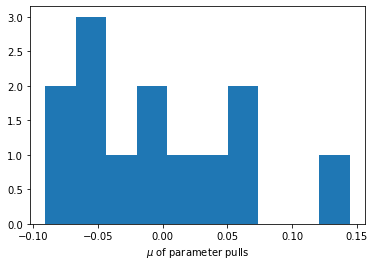

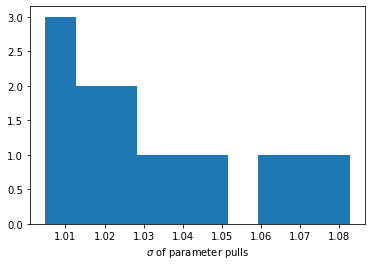

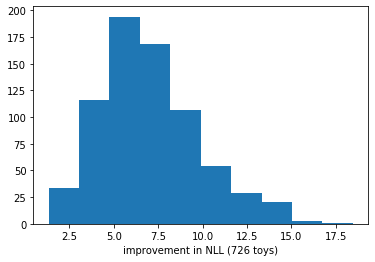

In [9]:
# input parameters used to generate the toys (edit here)
#inputp = {'D1_2010_mass': 2.01026, 'D1_2010_width': 8.34e-05, 'B->D1_2010.DsD1_2010->D.Pi_total_0r': -2.588549148364694, 'B->D1_2010.DsD1_2010->D.Pi_total_0i': 0.42553921351292945, 'B->D1_2010.Ds_g_ls_0r': 1.0, 'B->D1_2010.Ds_g_ls_0i': 0.0, 'D1_2010->D.Pi_g_ls_0r': 1.0, 'D1_2010->D.Pi_g_ls_0i': 0.0, 'D2_2460_mass': 2.4611, 'D2_2460_width': 0.0473, 'D1_2600_mass': 2.627, 'D1_2600_width': 0.141, 'D1_2007_mass': 2.00685, 'D1_2007_width': 0.0001, 'Z0_mass': 2.9467391531040827, 'Z0_width': 0.12481477429490542, 'DPi_S_point_0r': -0.19911794895263046, 'DPi_S_point_0i': -1.4451615282649009, 'DPi_S_point_1r': 0.27144830365932676, 'DPi_S_point_1i': -1.302492201933774, 'DPi_S_point_2r': 0.7721596130582159, 'DPi_S_point_2i': -0.9127099539484802, 'DPi_S_point_3r': 1.0140102804386304, 'DPi_S_point_3i': -0.6160287456880522, 'DPi_S_point_4r': 1.0, 'DPi_S_point_4i': 0.0, 'DPi_S_point_5r': 0.5150010591281244, 'DPi_S_point_5i': 0.2593741341881862, 'DPi_S_point_6r': 0.4420394491261874, 'DPi_S_point_6i': 0.28973529495869915, 'DPi_S_point_7r': 0.08335948312738514, 'DPi_S_point_7i': 0.4503017178748642, 'DPi_S_point_8r': -0.026338600157121892, 'DPi_S_point_8i': 0.3513386087647376, 'DPi_S_point_9r': -0.18745527471898138, 'DPi_S_point_9i': 0.11386446981983736, 'DPi_S_point_10r': -0.029849538450901172, 'DPi_S_point_10i': 0.15933637066403225, 'B->D2_2460.DsD2_2460->D.Pi_total_0r': 1.0, 'B->D2_2460.DsD2_2460->D.Pi_total_0i': 0.0, 'B->D2_2460.Ds_g_ls_0r': 1.0, 'B->D2_2460.Ds_g_ls_0i': 0.0, 'D2_2460->D.Pi_g_ls_0r': 1.0, 'D2_2460->D.Pi_g_ls_0i': 0.0, 'B->D1_2600.DsD1_2600->D.Pi_total_0r': 0.3719950352882642, 'B->D1_2600.DsD1_2600->D.Pi_total_0i': 0.07720033218985604, 'B->D1_2600.Ds_g_ls_0r': 1.0, 'B->D1_2600.Ds_g_ls_0i': 0.0, 'D1_2600->D.Pi_g_ls_0r': 1.0, 'D1_2600->D.Pi_g_ls_0i': 0.0, 'B->D1_2007.DsD1_2007->D.Pi_total_0r': -2.588549148364694, 'B->D1_2007.DsD1_2007->D.Pi_total_0i': 0.42553921351292945, 'B->D1_2007.Ds_g_ls_0r': 1.0, 'B->D1_2007.Ds_g_ls_0i': 0.0, 'D1_2007->D.Pi_g_ls_0r': 1.0, 'D1_2007->D.Pi_g_ls_0i': 0.0, 'B->Z0.DZ0->Ds.Pi_total_0r': 0.10002047639529653, 'B->Z0.DZ0->Ds.Pi_total_0i': -0.026679566285233935, 'B->Z0.D_g_ls_0r': 1.0, 'B->Z0.D_g_ls_0i': 0.0, 'Z0->Ds.Pi_g_ls_0r': 1.0, 'Z0->Ds.Pi_g_ls_0i': 0.0, 'B->DPi_S.DsDPi_S->D.Pi_total_0r': 0.5324585398076508, 'B->DPi_S.DsDPi_S->D.Pi_total_0i': -1.0598657716967963, 'B->DPi_S.Ds_g_ls_0r': 1.0, 'B->DPi_S.Ds_g_ls_0i': 0.0, 'DPi_S->D.Pi_g_ls_0r': 1.0, 'DPi_S->D.Pi_g_ls_0i': 0.0}
inputp = {'D1_2010_mass': 2.01026, 'D1_2010_width': 8.34e-05, 'B->D1_2010.DsD1_2010->D.Pi_total_0r': -2.059734005536572, 'B->D1_2010.DsD1_2010->D.Pi_total_0i': -1.3470028546092274, 'B->D1_2010.Ds_g_ls_0r': 1.0, 'B->D1_2010.Ds_g_ls_0i': 0.0, 'D1_2010->D.Pi_g_ls_0r': 1.0, 'D1_2010->D.Pi_g_ls_0i': 0.0, 'D2_2460_mass': 2.4611, 'D2_2460_width': 0.0473, 'D1_2600_mass': 2.627, 'D1_2600_width': 0.141, 'D0_2300_mass': 2.343, 'D0_2300_width': 0.229, 'D1_2007_mass': 2.00685, 'D1_2007_width': 0.0001, 'Z0_mass': 2.8946954143428085, 'Z0_width': 0.15788689022196734, 'NR_DPi0_a': 0.6505711300089106, 'B->D2_2460.DsD2_2460->D.Pi_total_0r': 1.0, 'B->D2_2460.DsD2_2460->D.Pi_total_0i': 0.0, 'B->D2_2460.Ds_g_ls_0r': 1.0, 'B->D2_2460.Ds_g_ls_0i': 0.0, 'D2_2460->D.Pi_g_ls_0r': 1.0, 'D2_2460->D.Pi_g_ls_0i': 0.0, 'B->D1_2600.DsD1_2600->D.Pi_total_0r': 0.22173700531826807, 'B->D1_2600.DsD1_2600->D.Pi_total_0i': -0.07872235451707209, 'B->D1_2600.Ds_g_ls_0r': 1.0, 'B->D1_2600.Ds_g_ls_0i': 0.0, 'D1_2600->D.Pi_g_ls_0r': 1.0, 'D1_2600->D.Pi_g_ls_0i': 0.0, 'B->D0_2300.DsD0_2300->D.Pi_total_0r': -0.3215356915558408, 'B->D0_2300.DsD0_2300->D.Pi_total_0i': -0.22458284411777305, 'B->D0_2300.Ds_g_ls_0r': 1.0, 'B->D0_2300.Ds_g_ls_0i': 0.0, 'D0_2300->D.Pi_g_ls_0r': 1.0, 'D0_2300->D.Pi_g_ls_0i': 0.0, 'B->D1_2007.DsD1_2007->D.Pi_total_0r': -2.059734005536572, 'B->D1_2007.DsD1_2007->D.Pi_total_0i': -1.3470028546092274, 'B->D1_2007.Ds_g_ls_0r': 1.0, 'B->D1_2007.Ds_g_ls_0i': 0.0, 'D1_2007->D.Pi_g_ls_0r': 1.0, 'D1_2007->D.Pi_g_ls_0i': 0.0, 'B->Z0.DZ0->Ds.Pi_total_0r': -0.03182816701382982, 'B->Z0.DZ0->Ds.Pi_total_0i': -0.16007436532275515, 'B->Z0.D_g_ls_0r': 1.0, 'B->Z0.D_g_ls_0i': 0.0, 'Z0->Ds.Pi_g_ls_0r': 1.0, 'Z0->Ds.Pi_g_ls_0i': 0.0, 'B->NR_DPi0.DsNR_DPi0->D.Pi_total_0r': 0.3932580413648399, 'B->NR_DPi0.DsNR_DPi0->D.Pi_total_0i': -1.573483320593986, 'B->NR_DPi0.Ds_g_ls_0r': 1.0, 'B->NR_DPi0.Ds_g_ls_0i': 0.0, 'NR_DPi0->D.Pi_g_ls_0r': 1.0, 'NR_DPi0->D.Pi_g_ls_0i': 0.0}
is_pull = True
#inputff = [{'D2_2460': 0.24884545382471618, 'D1_2600': 0.044256736167358014, 'D1_2010': 0.140295790695376, 'Z0': 0.013927905454883382, 'DPi_S': 0.5770323692158913}, {'D2_2460': 0.23620752779648313, 'D1_2600': 0.04280599812908796, 'D1_2007': 0.15161270173201372, 'Z0': 0.013646229556093568, 'DPi_S': 0.5783163296197019}]
inputff = [{'D2_2460': 0.23840631772729043, 'D1_2600': 0.016263543690087173, 'D0_2300': 0.10871965111170709, 'D1_2010': 0.1183027961495396, 'Z0': 0.026695859425835276, 'NR_DPi0': 0.17176635158624265}, {'D2_2460': 0.2274463740198849, 'D1_2600': 0.015810173021387257, 'D0_2300': 0.1069162226948219, 'D1_2007': 0.12849423718337186, 'Z0': 0.026302942835069704, 'NR_DPi0': 0.17897003691655108}]

with open("/Users/lyret/Desktop/tfpwa_log/MDfitfrac.txt") as f: # input log file (edit here)
    string = f.read()

aa = string.split("$$$$$ Start fit")[1:] # the header of each script
# pre-defined lists used to extract the arrays from the log file
sdic_v = []; sdic_e = []; simpNLL = []; sffBz_v = []; sffBz_e = []; sffBp_v = []; sffBp_e = []
cdic_v = []; cdic_e = []; cimpNLL = []; cffBz_v = []; cffBz_e = []; cffBp_v = []; cffBp_e = []
for i in aa:
    tmp = i.split("@@@@@")[-6].split('\n'); dic = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}dic_v"].append(dic) # tmp[0][0] is either "s" or "c"
    tmp = i.split("@@@@@")[-5].split('\n'); dic = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}dic_e"].append(dic)
    tmp = i.split("@@@@@")[-4].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}impNLL"].append(arr)
    try:
        tmp = i.split("@@@@@")[-3].split('\n')
    except:
        print(i.split("@@@@@"))
        raise
    dic = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}dic_v"].append(dic)
    tmp = i.split("@@@@@")[-2].split('\n'); dic = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}dic_e"].append(dic)
    tmp = i.split("@@@@@")[-1].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}impNLL"].append(arr)
    # fit-fractions
    tmp = i.split("@###@")[-8].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBz_v"].append(arr)
    tmp = i.split("@###@")[-7].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBz_e"].append(arr)
    tmp = i.split("@###@")[-6].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBp_v"].append(arr)
    tmp = i.split("@###@")[-5].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBp_e"].append(arr)
    tmp = i.split("@###@")[-4].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBz_v"].append(arr)
    tmp = i.split("@###@")[-3].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBz_e"].append(arr)
    tmp = i.split("@###@")[-2].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBp_v"].append(arr)
    tmp = i.split("@###@")[-1].split('\n'); arr = json.loads(tmp[1].replace("'",'"')); locals()[f"{tmp[0][0]}ffBp_e"].append(arr)

sdic = sdic_v[0].copy(); serr = sdic_e[0].copy(); sffBz = sffBz_v[0].copy(); sfeBz = sffBz_e[0].copy(); sffBp = sffBp_v[0].copy(); sfeBp = sffBp_e[0].copy(); 
for vname in sdic:
    for ii in range(1,len(sdic_v)):
        sdic[vname] += sdic_v[ii][vname]
        serr[vname] += sdic_e[ii][vname]
for reson in sffBz:
    for ii in range(1,len(sffBz_v)):
        sffBz[reson] += sffBz_v[ii][reson]
        sfeBz[reson] += sffBz_e[ii][reson]
for reson in sffBp:
    for ii in range(1,len(sffBp_v)):
        sffBp[reson] += sffBp_v[ii][reson]
        sfeBp[reson] += sffBp_e[ii][reson]
cdic = cdic_v[0].copy(); cerr = cdic_e[0].copy(); cffBz = cffBz_v[0].copy(); cfeBz = cffBz_e[0].copy(); cffBp = cffBp_v[0].copy(); cfeBp = cffBp_e[0].copy(); 
for vname in cdic:
    for ii in range(1,len(cdic_v)):
        cdic[vname] += cdic_v[ii][vname]
        cerr[vname] += cdic_e[ii][vname]
for reson in cffBz:
    for ii in range(1,len(cffBz_v)):
        cffBz[reson] += cffBz_v[ii][reson]
        cfeBz[reson] += cffBz_e[ii][reson]
for reson in cffBp:
    for ii in range(1,len(cffBp_v)):
        cffBp[reson] += cffBp_v[ii][reson]
        cfeBp[reson] += cffBp_e[ii][reson]
# now all arrays are saved into those pre-defined lists.

mode = "cfit" # cfit or sfit (edit here)
dic = locals()[f"{mode[0]}dic"]; err = locals()[f"{mode[0]}err"]; impNLL = np.concatenate(locals()[f"{mode[0]}impNLL"])
ffBz = locals()[f"{mode[0]}ffBz"]; feBz = locals()[f"{mode[0]}feBz"]; ffBp = locals()[f"{mode[0]}ffBp"]; feBp = locals()[f"{mode[0]}feBp"]; 

# function used to veto the toys whose pull of parameter "valname" is larger than value "cutpullval"
def cutvv(valname, cutpullval):
    j = 0
    for i in (np.array(dic[valname])-inputp[valname])/err[valname]:
        if abs(i)>cutpullval:
            for vv in dic:
                if dic[vv]:
                    tmp1 = dic[vv].pop(j)
                    tmp2 = err[vv].pop(j)
                    tmp3 = inputp[vv]
                    #print(f"{vv} input:{tmp3:.2g} mean:{tmp1:.2g} sigma:{tmp2:.2g} pull:{(tmp1-tmp3)/tmp2:.2g}")
            print("Veto 1 toy.") # it will print everytime a toy is vetoed
        else:
            j += 1
# the cuts that you want to set (edit here) (by default there is no need to veto toys)
#cutvv('DPi_S_point_8r', 6)
#cutvv('DPi_S_point_10r', 6)
#cutvv('DPi_S_point_10i', 6)
#cutvv('B->D1_2600.DsD1_2600->D.Pi_total_0r', 6)
#cutvv('B->D1_2600.DsD1_2600->D.Pi_total_0i', 6)

mu_list = []
sigma_list = []
Ntoy = len(dic[vname])
print(f"Sample amount {Ntoy}") # number of toy after cuts
i = 0
for vname in dic:
    if not dic[vname]:
        continue
    val = inputp[vname]
    if is_pull is True:
        if vname == "NR_DPi0_a":
            pull = (abs(np.array(dic[vname]))-val)/err[vname]
        else:
            pull = (np.array(dic[vname])-val)/err[vname]
        prange = max(5, max(abs(pull)))
        plt.xlim([-prange,prange])
        x = np.linspace(-prange, prange, 100)
    else:
        pull = np.array(dic[vname])
    _, bins, _ = plt.hist(pull)
    #mu, sigma = stats.norm.fit(pull)
    fitter = NLLfunc(pull)
    fitter.migrad()
    mu = fitter.values["mu"]
    mu_list.append(mu)
    sigma = fitter.values["sigma"]
    sigma_list.append(sigma)
    merr = fitter.errors["mu"]
    serr = fitter.errors["sigma"]

    x = np.linspace(min(pull), max(pull), 100)
    binwidth = np.mean(bins[1:]-bins[:-1])
    y = stats.norm.pdf(x, mu, sigma)*Ntoy*binwidth
    plt.plot(x, y, "r-")
    if is_pull is True:
        plt.title(f"Pull of {vname}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    else:
        plt.title(f"{vname}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    plt.savefig(f"tftmp/DDspi/{i}") # save path of parameter pull (edit here)
    plt.clf()
    i+=1
for reson in ffBz:
    val = inputff[0][reson]
    if is_pull is True:
        pull = (np.array(ffBz[reson])-val)/feBz[reson]
        prange = max(5, max(abs(pull)))
        plt.xlim([-prange,prange])
        x = np.linspace(-prange, prange, 100)
    else:
        pull = np.array(dic[reson])
    _, bins, _ = plt.hist(pull)
    fitter = NLLfunc(pull)
    fitter.migrad()
    mu = fitter.values["mu"]; sigma = fitter.values["sigma"]
    merr = fitter.errors["mu"]; serr = fitter.errors["sigma"]
    x = np.linspace(min(pull), max(pull), 100)
    binwidth = np.mean(bins[1:]-bins[:-1])
    y = stats.norm.pdf(x, mu, sigma)*Ntoy*binwidth
    plt.plot(x, y, "r-")
    if is_pull is True:
        plt.title(f"Pull of {reson}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    else:
        plt.title(f"{reson}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    plt.savefig(f"tftmp/DDspi/ffBz_{reson}") # save path of Bz fit-fractions pull (edit here)
    plt.clf()
for reson in ffBp:
    val = inputff[1][reson]
    if is_pull is True:
        pull = (np.array(ffBp[reson])-val)/feBp[reson]
        prange = max(5, max(abs(pull)))
        plt.xlim([-prange,prange])
        x = np.linspace(-prange, prange, 100)
    else:
        pull = np.array(dic[reson])
    _, bins, _ = plt.hist(pull)
    fitter = NLLfunc(pull)
    fitter.migrad()
    mu = fitter.values["mu"]; sigma = fitter.values["sigma"]
    merr = fitter.errors["mu"]; serr = fitter.errors["sigma"]
    x = np.linspace(min(pull), max(pull), 100)
    binwidth = np.mean(bins[1:]-bins[:-1])
    y = stats.norm.pdf(x, mu, sigma)*Ntoy*binwidth
    plt.plot(x, y, "r-")
    if is_pull is True:
        plt.title(f"Pull of {reson}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    else:
        plt.title(f"{reson}\nμ={error_print(mu, merr)}, σ={error_print(sigma, serr)}", fontsize="x-large")
    plt.savefig(f"tftmp/DDspi/ffBp_{reson}") # save path of Bp fit-fractions pull (edit here)
    plt.clf()

print(f"This is {mode} with input parameters:\n{inputp}")
if is_pull:
    plt.hist(mu_list)
    plt.xlabel("$\mu$ of parameter pulls")
    plt.savefig(f"tftmp/DDspi/mu_pull") # (edit here)
    plt.show()
    plt.hist(sigma_list)
    plt.xlabel("$\sigma$ of parameter pulls")
    plt.savefig(f"tftmp/DDspi/sigma_pull") # (edit here)
    plt.show()
plt.hist(impNLL)
plt.xlabel(f"improvement in NLL ({Ntoy} toys)")
plt.savefig(f"tftmp/DDspi/improve_NLL") # (edit here)
plt.show()

### LaTeX output
The codes below are copied from `latex_out.py`. Load these functions first.

In [10]:
def error_print(x, err=None):
    import math
    if err is None:
        return ("{}").format(x)
    if err <= 0 or math.isnan(err):
        return ("{} ? {}").format(x, err)
    d = math.ceil(math.log10(err))
    b = 10 ** d
    b_err = err / b
    b_val = x / b
    if b_err < 0.355:  # 0.100 ~ 0.354
        dig = 2
    elif b_err < 0.950:  # 0.355 ~ 0.949
        dig = 1
    else:  # 0.950 ~ 0.999
        dig = 0
    err = round(b_err, dig) * b
    x = round(b_val, dig) * b
    d_p = dig - d
    if d_p > 0:
        return ("{0:.%df}±{1:.%df}" % (d_p, d_p)).format(x, err)
    return ("{0:.0f}±{1:.0f}").format(x, err)
class latex_out(object):
    def __init__(self, cand_dic, param_dic):
        self.cand_dic = cand_dic
        self.param_dic = param_dic

    def _get_point(self, s):
        import re
        partten = re.compile(r"([^\s]+)\s+([+-.e1234567890]+)\s+")
        ret = {}
        intersum = 0
        for i in s.split("\n"):
            g = partten.match(i)
            if g:
                name, fracv, _, error = i.split(" ")
                name = name.split("x")
                fracv = float(fracv)*100; error = float(error)*100
                fracv, error = error_print(fracv, error).split("±")
                fracv = float(fracv); error = float(error)
                if fracv>=0.1:
                    frac =f"${fracv}\pm{error}$"
                else:
                    frac = "0.0"
                if len(name) == 1:
                    l, r = name*2
                    intersum += fracv
                elif len(name) == 2:
                    l, r = name
                else:
                    raise Exception("error {}".format(name))
                if l not in ret:
                    ret[l] = {}
                ret[l][r] = frac
        return ret, intersum
    def _get_table(self, s):
        idx = list(s)
        n_idx = len(idx)
        idx_map = dict(zip(idx, range(n_idx)))
        ret = []
        for i in range(n_idx):
            ret.append([0.0 for j in range(n_idx)])
        for i, k in s.items():
            for j, v in k.items():
                ret[idx_map[i]][idx_map[j]] = v
        return idx, ret
    def _frac_table(self, frac_txt, cand_dic):
        s, intersum = self._get_point(frac_txt)
        idx, table = self._get_table(s)
        ret = []
        for i, k in enumerate(table):
            tmp = []
            for j, v in enumerate(k):
                if i < j:
                    tmp.append("-")
                else:
                    tmp.append("{}".format(v))
            ret.append(tmp)
        lenk = len(ret[0])
        ret_string = ""
        for i, k in zip(idx, ret):
            ret_string += (cand_dic[i]+"\t&")
            for v, kk in zip(k, range(lenk)):
                if kk == lenk-1:
                    ret_string += (v+"\\\\")
                else:
                    ret_string += (v+"\t&")
            ret_string += "\n"
        return ret_string, intersum, lenk
    def fitfrac_table(self, tfpwa_string, cand_dic=None):
        if cand_dic == None:
            cand_dic = self.cand_dic
        ret_string, intersum, lenk = self._frac_table(tfpwa_string, cand_dic)
        head = r"""\begin{table}[htp]
\caption{Fit-fraction interference table. (All terms smaller than 0.1\% are given as 0 without uncertainty.)}
\begin{center}\resizebox{\textwidth}{!}{\begin{tabular}{ | c | """
        for i in range(lenk):
            head += "c "
        head += "| }\n\hline\n"
        tail =r"""\hline
\multicolumn{"""+str(lenk+1)+r"""}{| l |}{Sum of fit-fractions: """+f"{intersum:.1f}"+r""" (units: \%)}\\
\hline
\end{tabular}}\end{center}
\label{tab:interference_table}
\end{table}"""
        outstring = head+ret_string+tail
        return outstring
    
    
    def _process_input_param_string(self, inpstr):
        line = inpstr.split("\n")
        self.param_var_dic = {}
        for l in line:
            ll = l.split(" ")
            if len(ll) == 2:
                self.param_var_dic[ll[0]] = str(ll[1])
            elif len(ll) == 4:
                self.param_var_dic[ll[0]] = f"${ll[1]}\pm{ll[3]}$"
    def _traverse_dic(self, dic, layer=1, string=None):
        if string is None:
            string = ""
        for i in dic:
            if i == "Amplitude":
                tstr = string
            else:
                tstr = "\t"
            if layer == 1:
                tstr += f"\\hline\n{i}"
            else:
                #if layer == 2:
                tstr += "\t& "
                tstr += f"{i}\t& "
            if type(dic[i]) is dict:
                self._traverse_dic(dic[i], layer+1, tstr)
            else:
                if dic[i] in self.param_var_dic:
                    if i == "Mass" or i == "Width":
                        if r"\pm" not in self.param_var_dic[dic[i]]:
                            continue # skip fixed PDG mass and width
                    tstr += (self.param_var_dic[dic[i]]+"\\\\\n")
                    self.param_latex_table += tstr
    def param_table(self, inpstr, param_dic=None):
        if param_dic is None:
            param_dic = self.param_dic
        self._process_input_param_string(inpstr)
        self.param_latex_table = ""
        self._traverse_dic(param_dic)
        outstring = r"""\begin{center}\begin{longtable}{ c c c }
  \caption{Results of fit parameters.}
  \label{tab:param_app}\\
    \hline\hline\hline
    \multicolumn{2}{c}{Parameter} & Fit result \\
    \hline
    \endfirsthead
    
    \multicolumn{3}{c}%
{{\tablename\ \thetable{} (continued)}} \\
    \hline\hline
    \multicolumn{2}{c}{Parameter} & Fit result \\
    \hline
    \endhead
    
    \hline \multicolumn{3}{r}{{Continued next page}} \\ \hline\hline
    \endfoot
    
    \hline\hline\hline
    \endlastfoot
    """
        outstring += self.param_latex_table
        outstring += r"\end{longtable}\end{center}"
        return outstring


cand_dic = {
    "D1_2007": "$D^*(2007)^0$",
    "D1_2010": "$D^*(2010)^-$",
    "D0_2300": "$D_0^*(2300)$",
    "D2_2460": "$D_2^*(2460)$",
    "D1_2600": "$D_1^*(2600)$",
    "D3_2750": "$D_3^*(2750)$",
    "D1_2760": "$D_1^*(2760)$", # only seen neutral
    "DJ_2640": "$D_J^*(2640)$", # only seen charged
    "DJ_3000": "$D_J^*(3000)$", # only seen neutral
    "D0_2900": "$D_0^*(2900)$", # theoretical prediction
    "DPi_S": r"spline($D\pi$)S",
    "NR_DPi0": r"NR($D\pi$)S",
    "Z0": "$Z_0$",
    "Z1": "$Z_1$",
    "Z2": "$Z_2$",
    "Z3": "$Z_3$",
    "Dstar": r"$D\pi$",
    "DsPi": r"$D_s\pi$",
    "DDs": "$DD_s$",
}
assist_dic = {
    "$D^*(2007)^0$": ["B->D1_2007.DsD1_2007->D.Pi_total_0", "D1_2007"],
    "$D^*(2010)^-$": ["B->D1_2010.DsD1_2010->D.Pi_total_0", "D1_2010"],
    "$D_0^*(2300)$": ["B->D0_2300.DsD0_2300->D.Pi_total_0", "D0_2300"],
    "$D_2^*(2460)$": ["B->D2_2460.DsD2_2460->D.Pi_total_0", "D2_2460"],
    "$D_1^*(2600)$": ["B->D1_2600.DsD1_2600->D.Pi_total_0", "D1_2600"],
    "$D_3^*(2750)$": ["B->D3_2750.DsD3_2750->D.Pi_total_0", "D3_2750"],
    "$D_1^*(2760)$": ["B->D1_2760.DsD1_2760->D.Pi_total_0", "D1_2760"],
    "$D_J^*(2640)$": ["B->DJ_2640.DsDJ_2640->D.Pi_total_0", "DJ_2640"],
    "$D_J^*(3000)$": ["B->DJ_3000.DsDJ_3000->D.Pi_total_0", "DJ_3000"],
    "$D_0^*(2900)$": ["B->D0_2900.DsD0_2900->D.Pi_total_0", "D0_2900"],
    r"spline($D\pi$)S": ["B->DPi_S.DsDPi_S->D.Pi_total_0", "DPi_S_point"],
    r"NR($D\pi$)S": ["B->NR_DPi0.DsNR_DPi0->D.Pi_total_0", "NR_DPi0"],
    "$Z_0$": ["B->Z0.DZ0->Ds.Pi_total_0", "Z0"],
    "$Z_1$": ["B->Z1.DZ1->Ds.Pi_total_0", "Z1"],
    "$Z_2$": ["B->Z2.DZ2->Ds.Pi_total_0", "Z2"],
    "$Z_3$": ["B->Z3.DZ3->Ds.Pi_total_0", "Z3"],
}
param_dic = {}
for i in assist_dic:
    param_dic[i] = {"Amplitude": assist_dic[i][0]+"r", "Phase": assist_dic[i][0]+"i"}
    if i[0] == "$":
        param_dic[i]["Mass"] = assist_dic[i][1]+"_mass"
        param_dic[i]["Width"] = assist_dic[i][1]+"_width"
    elif i == r"NR($D\pi$)S":
        param_dic[i][r"Exponential $\alpha$"] = assist_dic[i][1]+"_a"
    elif i == r"spline($D\pi$)S":
        for j in range(12):
            param_dic[i][f"Spline point {j} x"] = assist_dic[i][1]+f"_{j}r"
            param_dic[i][f"Spline point {j} y"] = assist_dic[i][1]+f"_{j}i"

ltx = latex_out(cand_dic, param_dic)

Paste the output from `fit.py` to `instr` (under `########## fit results`) and `tfpwa_string` (under `########## fit fractions`) below. The running the cell you will get the latex codes you can put in the Analysis Note.

In [11]:
instr = """
D1_2010_mass 2.01026
D1_2010_width 8.34e-05
B->D1_2010.DsD1_2010->D.Pi_total_0r 2.79 +/- 0.12
B->D1_2010.DsD1_2010->D.Pi_total_0i -3.12 +/- 0.07
B->D1_2010.Ds_g_ls_0r 1.0
B->D1_2010.Ds_g_ls_0i 0.0
D1_2010->D.Pi_g_ls_0r 1.0
D1_2010->D.Pi_g_ls_0i 0.0
D2_2460_mass 2.4611
D2_2460_width 0.0473
D1_2600_mass 2.627
D1_2600_width 0.141
D1_2007_mass 2.00685
D1_2007_width 0.0001
Z0_mass 2.959 +/- 0.017
Z0_width 0.192 +/- 0.034
Z1_mass 2.919 +/- 0.018
Z1_width 0.20 +/- 0.05
DPi_S_point_0r 0.08 +/- 0.25
DPi_S_point_0i -1.60 +/- 0.22
DPi_S_point_1r 0.38 +/- 0.11
DPi_S_point_1i -1.35 +/- 0.08
DPi_S_point_2r 0.69 +/- 0.07
DPi_S_point_2i -0.96 +/- 0.07
DPi_S_point_3r 0.99 +/- 0.05
DPi_S_point_3i -0.60 +/- 0.07
DPi_S_point_4r 1.0
DPi_S_point_4i 0.0
DPi_S_point_5r 0.541 +/- 0.034
DPi_S_point_5i 0.21 +/- 0.05
DPi_S_point_6r 0.46 +/- 0.04
DPi_S_point_6i 0.226 +/- 0.035
DPi_S_point_7r 0.18 +/- 0.06
DPi_S_point_7i 0.408 +/- 0.033
DPi_S_point_8r 0.01 +/- 0.05
DPi_S_point_8i 0.329 +/- 0.028
DPi_S_point_9r -0.123 +/- 0.027
DPi_S_point_9i -0.034 +/- 0.031
DPi_S_point_10r 0.08 +/- 0.06
DPi_S_point_10i 0.00 +/- 0.05
B->D2_2460.DsD2_2460->D.Pi_total_0r 1.0
B->D2_2460.DsD2_2460->D.Pi_total_0i 0.0
B->D2_2460.Ds_g_ls_0r 1.0
B->D2_2460.Ds_g_ls_0i 0.0
D2_2460->D.Pi_g_ls_0r 1.0
D2_2460->D.Pi_g_ls_0i 0.0
B->D1_2600.DsD1_2600->D.Pi_total_0r 0.320 +/- 0.026
B->D1_2600.DsD1_2600->D.Pi_total_0i 0.1 +/- 0.1
B->D1_2600.Ds_g_ls_0r 1.0
B->D1_2600.Ds_g_ls_0i 0.0
D1_2600->D.Pi_g_ls_0r 1.0
D1_2600->D.Pi_g_ls_0i 0.0
B->D1_2007.DsD1_2007->D.Pi_total_0r 2.785962394983777
B->D1_2007.DsD1_2007->D.Pi_total_0i -3.1211339423275346
B->D1_2007.Ds_g_ls_0r 1.0
B->D1_2007.Ds_g_ls_0i 0.0
D1_2007->D.Pi_g_ls_0r 1.0
D1_2007->D.Pi_g_ls_0i 0.0
B->Z0.DZ0->Ds.Pi_total_0r 0.19 +/- 0.04
B->Z0.DZ0->Ds.Pi_total_0i 0.20 +/- 0.22
B->Z0.D_g_ls_0r 1.0
B->Z0.D_g_ls_0i 0.0
Z0->Ds.Pi_g_ls_0r 1.0
Z0->Ds.Pi_g_ls_0i 0.0
B->Z1.DZ1->Ds.Pi_total_0r 0.31 +/- 0.09
B->Z1.DZ1->Ds.Pi_total_0i 1.12 +/- 0.24
B->Z1.D_g_ls_0r 1.0
B->Z1.D_g_ls_0i 0.0
Z1->Ds.Pi_g_ls_0r 1.0
Z1->Ds.Pi_g_ls_0i 0.0
B->DPi_S.DsDPi_S->D.Pi_total_0r 1.16 +/- 0.05
B->DPi_S.DsDPi_S->D.Pi_total_0i -1.04 +/- 0.04
B->DPi_S.Ds_g_ls_0r 1.0
B->DPi_S.Ds_g_ls_0i 0.0
DPi_S->D.Pi_g_ls_0r 1.0
DPi_S->D.Pi_g_ls_0i 0.0
"""
tfpwa_string = """
D2_2460 0.222 +/- 0.007
D1_2600 0.0140 +/- 0.0027
D1_2600xD2_2460 0.0001 +/- 0.0001
DJ_3000 0.0050 +/- 0.0014
DJ_3000xD1_2600 0.000028 +/- 0.000005
DJ_3000xD2_2460 -0.000058 +/- 0.000012
D1_2007 0.169 +/- 0.013
D1_2007xDJ_3000 0.00001 +/- 0.00001
D1_2007xD1_2600 0.0182 +/- 0.0026
D1_2007xD2_2460 -0.00020 +/- 0.00011
Z0 0.023 +/- 0.005
Z0xD1_2007 0.008 +/- 0.005
Z0xDJ_3000 0.0019 +/- 0.0008
Z0xD1_2600 0.0080 +/- 0.0016
Z0xD2_2460 0.0121 +/- 0.0032
DPi_S 0.492 +/- 0.018
DPi_SxZ0 0.029 +/- 0.011
DPi_SxD1_2007 -0.00180 +/- 0.00019
DPi_SxDJ_3000 0.000014 +/- 0.000013
DPi_SxD1_2600 -0.00001 +/- 0.00005
DPi_SxD2_2460 -0.00017 +/- 0.00007
"""
ffltx=ltx.fitfrac_table(tfpwa_string)
parltx=ltx.param_table(instr)
print(ffltx)
print("\n\n")
print(parltx)

\begin{table}[htp]
\caption{Fit-fraction interference table. (All terms smaller than 0.1\% are given as 0 without uncertainty.)}
\begin{center}\resizebox{\textwidth}{!}{\begin{tabular}{ | c | c c c c c c | }
\hline
$D_2^*(2460)$	&$22.2\pm0.7$	&-	&-	&-	&-	&-\\
$D_1^*(2600)$	&0.0	&$1.4\pm0.27$	&-	&-	&-	&-\\
$D_J^*(3000)$	&0.0	&0.0	&$0.5\pm0.14$	&-	&-	&-\\
$D^*(2007)^0$	&0.0	&$1.82\pm0.26$	&0.0	&$16.9\pm1.3$	&-	&-\\
$Z_0$	&$1.21\pm0.32$	&$0.8\pm0.16$	&$0.19\pm0.08$	&$0.8\pm0.5$	&$2.3\pm0.5$	&-\\
spline($D\pi$)S	&0.0	&0.0	&0.0	&0.0	&$2.9\pm1.1$	&$49.2\pm1.8$\\
\hline
\multicolumn{7}{| l |}{Sum of fit-fractions: 92.5 (units: \%)}\\
\hline
\end{tabular}}\end{center}
\label{tab:interference_table}
\end{table}



\begin{center}\begin{longtable}{ c c c }
  \caption{Results of fit parameters.}
  \label{tab:param_app}\\
    \hline\hline\hline
    \multicolumn{2}{c}{Parameter} & Fit result \\
    \hline
    \endfirsthead
    
    \multicolumn{3}{c}%
{{\tablename\ \thetable{} (continued)}} \\
    \